# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
# !pip install python-crfsuite

In [11]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata
import pandas as pd

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)
    
    
    example of token: ['I','love','nlp']
    example of idx: 0, 1, 2
    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [188]:
#Visualize results by doing a quick test
print(get_features(["I", "AM", "1ron", "Man"], 0))
print(get_features(["I", "AM", "1ron", "Man"], 1))
print(get_features(["I", "AM", "1ron", "Man"], 2))
print(get_features(["I", "AM", "1ron", "Man"], 3))

['CAPITALIZATION', 'WORD_I']
['CAPITALIZATION', 'SUF_M', 'WORD_AM']
['HAS_NUM', 'SUF_n', 'SUF_on', 'SUF_ron', 'WORD_1ron']
['CAPITALIZATION', 'SUF_n', 'SUF_an', 'WORD_Man']


In [12]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [13]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [14]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [15]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [16]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [17]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [18]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [19]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.36       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.81      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Opinion', 'I-Quote', 'I-Soundtrack', 'B-Opinion', 'I-Origin', 'B-Soundtrack', 'B-Actor', 'I-Actor', 'B-Origin', 'B-Character_Name', 'I-Plot', 'I-Relationship', 'B-Plot', 'I-Year', 'I-Award', 'B-Award', 'B-Relationship', 'B-Year', 'I-Character_Name', 'O', 'I-Director', 'B-Director', 'B-Genre', 'B-Quote', 'I-Genre'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


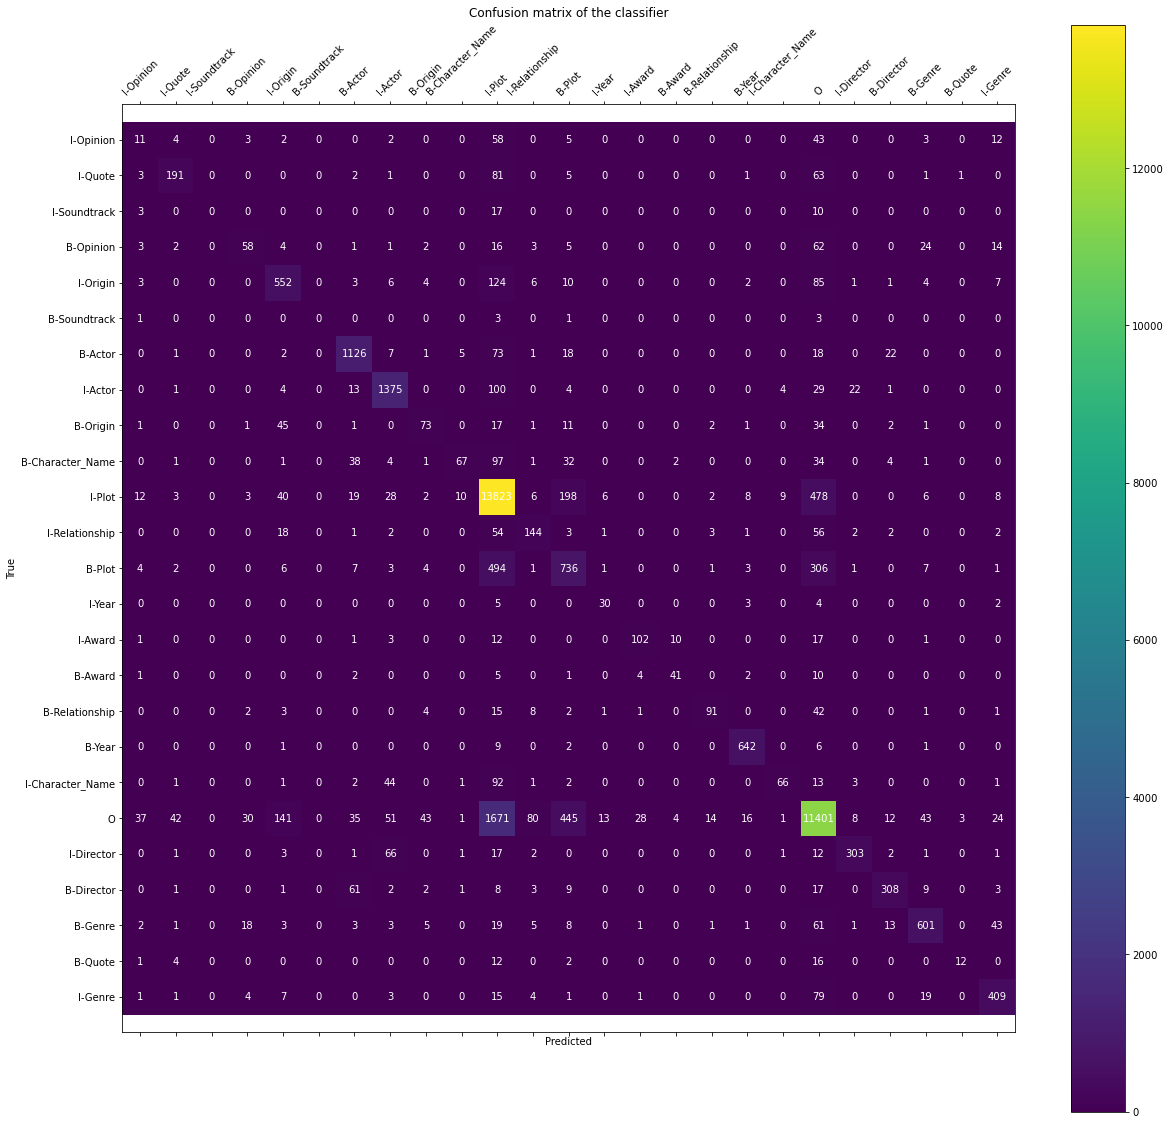

In [21]:
confusion_matrix_heatmap(y_test, preds)

In [22]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [23]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [24]:
print_transition_weights(ct._tagger.info().transitions.items())

8.731889 B-Actor  -> I-Actor
8.346452 B-Plot   -> I-Plot
8.063256 B-Director -> I-Director
7.853769 B-Origin -> I-Origin
7.729229 I-Plot   -> I-Plot
7.560399 I-Quote  -> I-Quote
7.407722 B-Character_Name -> I-Character_Name
7.347477 I-Origin -> I-Origin
7.267754 B-Relationship -> I-Relationship
7.142467 B-Quote  -> I-Quote
7.018631 I-Relationship -> I-Relationship
6.874474 I-Soundtrack -> I-Soundtrack
6.791274 I-Opinion -> I-Opinion
6.738424 B-Genre  -> I-Genre
6.696196 B-Soundtrack -> I-Soundtrack
6.590974 B-Award  -> I-Award
6.446605 B-Opinion -> I-Opinion
6.427469 I-Award  -> I-Award
6.361042 I-Genre  -> I-Genre
6.348052 I-Actor  -> I-Actor
6.227569 I-Character_Name -> I-Character_Name
5.431289 I-Director -> I-Director
4.813095 I-Year   -> I-Year
4.075799 B-Year   -> I-Year
3.774895 B-Character_Name -> B-Plot
3.561169 O        -> O
3.559177 I-Character_Name -> B-Plot
3.271588 O        -> B-Plot
3.204448 B-Plot   -> B-Character_Name
3.084227 B-Opinion -> B-Genre
3.018820 O        -> 

In [25]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [26]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.196527 B-Year   HAS_NUM
4.377805 B-Genre  WORD_animated
4.377179 I-Year   WORD_s
3.280417 B-Genre  WORD_thriller
3.007786 B-Quote  WORD_i
2.976568 I-Genre  WORD_animated
2.973407 B-Genre  WORD_action
2.909859 B-Plot   WORD_a
2.905342 B-Opinion WORD_blockbuster
2.686105 B-Award  WORD_oscar
2.666665 B-Genre  WORD_animation
2.598902 B-Relationship SUF_uel
2.574206 B-Director WORD_disney
2.557347 B-Opinion WORD_masterpiece
2.551999 I-Genre  WORD_fiction
2.546444 B-Award  SUF_car
2.518849 B-Relationship WORD_remake
2.460342 B-Actor  WORD_cher
2.438131 B-Genre  WORD_horror
2.420829 I-Genre  WORD_white
2.411938 B-Relationship WORD_sequel
2.407609 I-Genre  WORD_thriller
2.371395 B-Genre  WORD_slasher
2.367687 B-Genre  WORD_comedy
2.336496 B-Origin WORD_adapted
2.302117 I-Actor  WORD_cage
2.276304 B-Genre  WORD_documentary
2.225584 B-Director SUF_xar
2.225584 B-Director WORD_pixar
2.224878 B-Genre  WORD_romance
2.186996 B-Genre  WORD_war
2.181365 B-Award  WORD_won
2.174204 B-Plot   WORD_an
2.

# Start of Assignment 1

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


## 1.1) Train-validation split


To start, we first inspect the structure of the data. As shown below, it is in the form a list of tuples, where each tuple consists of a word and its respective NER tag. Moreover, note that there are no capitatizations and punctuations in the data, meaning it was probably pre-processed beforehand.

In [27]:
training_data[0:3]

[[('steve', 'B-Actor'),
  ('mcqueen', 'I-Actor'),
  ('provided', 'O'),
  ('a', 'O'),
  ('thrilling', 'B-Plot'),
  ('motorcycle', 'I-Plot'),
  ('chase', 'I-Plot'),
  ('in', 'I-Plot'),
  ('this', 'I-Plot'),
  ('greatest', 'B-Opinion'),
  ('of', 'I-Opinion'),
  ('all', 'I-Opinion'),
  ('ww', 'B-Plot'),
  ('2', 'I-Plot'),
  ('prison', 'I-Plot'),
  ('escape', 'I-Plot'),
  ('movies', 'I-Plot')],
 [('liza', 'B-Actor'),
  ('minnelli', 'I-Actor'),
  ('and', 'O'),
  ('joel', 'B-Actor'),
  ('gray', 'I-Actor'),
  ('won', 'B-Award'),
  ('oscars', 'I-Award'),
  ('for', 'O'),
  ('their', 'O'),
  ('roles', 'O'),
  ('in', 'O'),
  ('this', 'O'),
  ('1972', 'B-Year'),
  ('movie', 'O'),
  ('that', 'B-Plot'),
  ('follows', 'I-Plot'),
  ('nightclub', 'I-Plot'),
  ('entertainers', 'I-Plot'),
  ('in', 'I-Plot'),
  ('berlin', 'I-Plot'),
  ('as', 'I-Plot'),
  ('the', 'I-Plot'),
  ('nazis', 'I-Plot'),
  ('come', 'I-Plot'),
  ('to', 'I-Plot'),
  ('power', 'I-Plot')],
 [('what', 'O'),
  ('is', 'O'),
  ('that', 'O'

Since the question instructs us to do a deterministic split for the first 80% of the initial training set and the remaining 20% as the validation set, we do so:

In [28]:
train_pct_index = int(0.8 * len(training_data))

train_data, validation_data = training_data[:train_pct_index], training_data[train_pct_index:]

Let's now get a quick look of our splits by checking the number of instances/sentences and the number of words/tokens in both the training and validation sets. This also serves as way to check that the splits are correct.

### 1.1.1) Sentence Breakdown

In [29]:
print(f'Length of the old training set: {len(training_data)}')
print(f'Length of the new training set: {len(train_data)}, proportion of dataset:  {len(train_data)/len(training_data)}')
print(f'Length of the validation set: {len(validation_data)}, proportion of dataset:  {len(validation_data)/len(training_data)}')

Length of the old training set: 7816
Length of the new training set: 6252, proportion of dataset:  0.7998976458546572
Length of the validation set: 1564, proportion of dataset:  0.2001023541453429


### 1.1.2) Word/token Breakdown

In [30]:
print(f'Number of words in old training set: {sum([len(sent) for sent in training_data])}')
print(f'Number of words in the new training set: {sum([len(sent) for sent in train_data])}')
print(f'Number of words in the new validation set: {sum([len(sent) for sent in validation_data])}')

Number of words in old training set: 158823
Number of words in the new training set: 127519
Number of words in the new validation set: 31304


Indeed, we have split the initial training set by 80-20 at the sentence level

## 1.2) Training CRF on New Training Set:

Now we retrain the tagger code such that it is trained on our new training set.

In [31]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_CourseworkQ1.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_data, TAGGER_PATH)
print("done")

training tagger...
done


In [32]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

## 1.3) Define dataframe functions

To expedite the testing process, define some functions that create the token-level, sentence-level, and full dataframes for the any chosen dataset (e.g. testing, validation, and training). This allows for extra flexibility come testing later on.

### 1.3.1) Make a sentence dataframe function

Make a function that generates the token-level dataframe of the tokens in a particular dataset (could be train, test, etc). This will contain the predicted tags and actual tags of each token, as well as the token's sentence tag (i.e. which sentence it belongs to) and token order (where it is in the sentence).

In [33]:
def Make_Token_Dataframe(model, data) :
    
    '''
    data = a list of tuples where each tuple is a token and its corresponding tag
    model = a crf model
    '''
    
    print("testing tagger...")
    #Vector of predictions
    preds_val = []

    #Vector of truths
    y_val = []

    #Vector of tokens
    tokens_val = []

    #Vector of text indices
    text_indices = []


    #Vector of text indices
    token_order = []

    #Initialize text index counter
    text_index = 0
    for sent in data:


        sent_preds = [x[1] for x in model.tag([s[0] for s in sent])] #get predictions
        sent_true = [s[1] for s in sent] # get classes 
        sent_token = [s[0] for s in sent] # get tokens
        sent_index = np.repeat(text_index, len(sent))
        sent_order = range(len(sent))

        preds_val.extend(sent_preds)
        y_val.extend(sent_true)
        tokens_val.extend(sent_token)
        text_indices.extend(sent_index)
        token_order.extend(sent_order)


        text_index += 1 #add 1 after each sentence pass

    print("Done. Token-level DF is generated")
    
    DF = pd.DataFrame({'Sent_index':text_indices,'token':tokens_val,'token_order':token_order,'y':y_val,'pred':preds_val})
    
    return DF

### 1.3.2) Make a sentence dataframe function

Make sentence dataframe function which makes a dataframe of all sentence in a specified dataset.


In [34]:
def Make_Sentence_Dataframe(data):
    
    '''
    data = a list of tuples where each tuple is a token and its corresponding tag
    '''
    
    DF = pd.DataFrame({'Sent_index':range(len(data)),'text':data})
    
    print("Done. Sentence-level DF is generated")
    
    return DF

### 1.3.3) Make a full dataframe function

This function just combines the token-level and sentence-level DFS into one full DF.

In [35]:
def Make_Full_Dataframe(DF, Sent_DF):
    '''
    DF = token level datagrame
    Sent_DF = sentence level DF
    '''
    
    DF_Full = pd.merge(Sent_DF, DF, how="right", on=["Sent_index"])
    
    #prints an error if the number of observations in the token-level df is not the same as that of the full df
    if DF_Full.shape[0] != DF.shape[0]:
        print('Rows in full validation DB don\'t match the original DB.')
        return
    
    
    print("Done. Full DF is generated")
    
    return DF_Full

## 1.4) Test the model on the validation. Save pertinent dataframes.

In [36]:
#Create dataframes of the validation set

#Token Level DF
Validation_DF = Make_Token_Dataframe(model = ct, data = validation_data)

#Sentence level DF
Validation_Sent_DF = Make_Sentence_Dataframe(data = validation_data)

Validation_DF_Full = Make_Full_Dataframe(DF = Validation_DF,Sent_DF = Validation_Sent_DF)



testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


### 1.4.1) Quick overview of generated dataframes

In [37]:
print(f'number of tokens in the validation set: {Validation_DF.shape[0]}')
print(f"number of sentences in the validation set: {Validation_Sent_DF.shape[0]}")

print("Quick overview of token-level df")
display(Validation_DF[0:60])
print("Quick overview of sentence-level df")
display(Validation_Sent_DF[0:3])
print("Quick overview of full df")
display(Validation_DF_Full[0:10])


number of tokens in the validation set: 31304
number of sentences in the validation set: 1564
Quick overview of token-level df


Sent_index         token  token_order               y     pred
0            0          omar            0         B-Actor  B-Actor
1            0        sharif            1         I-Actor  I-Actor
2            0            is            2               O        O
3            0             a            3          B-Plot   B-Plot
4            0       married            4          I-Plot   I-Plot
5            0           man            5          I-Plot   I-Plot
6            0           who            6          I-Plot   I-Plot
7            0         falls            7          I-Plot   I-Plot
8            0            in            8          I-Plot   I-Plot
9            0          love            9          I-Plot   I-Plot
10           0          with           10          I-Plot   I-Plot
11           0         julie           11         B-Actor   I-Plot
12           0      christie           12         I-Actor   I-Plot
13           0        during           13          B-Plot   I-Plot
14           0           the           14          I-Plot   I-Plot
15           0     bolshevik           15          I-Plot   I-Plot
16           0    revolution           16          I-Plot   I-Plot
17           0            in           17               O        O
18           0          this           18               O        O
19           0          1965           19          B-Year   B-Year
20           0         oscar           20         B-Award  B-Award
21           0        winner           21               O  I-Award
22           1            on            0          B-Plot        O
23           1             a            1          I-Plot   B-Plot
24           1      vacation            2          I-Plot   I-Plot
25           1            in            3          I-Plot   I-Plot
26           1         paris            4          I-Plot   I-Plot
27           1           one            5          I-Plot   I-Plot
28           1            of            6          I-Plot   I-Plot
29           1         three            7          I-Plot   I-Plot
30           1     travelers            8          I-Plot   I-Plot
31           1            is            9          I-Plot   I-Plot
32           1      mistaken           10          I-Plot   I-Plot
33           1           for           11          I-Plot   I-Plot
34           1             a           12          I-Plot   I-Plot
35           1       british           13          I-Plot   I-Plot
36           1       heiress           14          I-Plot   I-Plot
37           2            on            0               O        O
38           2           the            1               O        O
39           2          film            2               O        O
40           2             s            3               O        O
41           2    soundtrack            4               O  B-Actor
42           2         album            5               O  I-Actor
43           2          this            6               O        O
44           2  instrumental            7  B-Relationship        O
45           2         piece            8  I-Relationship        O
46           2            is            9  I-Relationship        O
47           2        called           10  I-Relationship        O
48           2        titles           11  I-Relationship        O
49           2       because           12               O        O
50           2            of           13               O        O
51           2           its           14               O        O
52           2           use           15               O        O
53           2            in           16               O        O
54           2           the           17               O        O
55           2         movie           18               O        O
56           2             s           19               O        O
57           2       opening           20               O        O
58           2        titles           21          

Quick overview of sentence-level df


Sent_index                                               text
0           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...
1           1  [(on, B-Plot), (a, I-Plot), (vacation, I-Plot)...
2           2  [(on, O), (the, O), (film, O), (s, O), (soundt...

Quick overview of full df


Sent_index                                               text    token  \
0           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...     omar   
1           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...   sharif   
2           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...       is   
3           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...        a   
4           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...  married   
5           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...      man   
6           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...      who   
7           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...    falls   
8           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...       in   
9           0  [(omar, B-Actor), (sharif, I-Actor), (is, O), ...     love   

   token_order        y     pred  
0            0  B-Actor  B-Actor  
1            1  I-Actor  I-Actor  
2            2        O        O  
3            3   B-Plot   B-Plot  
4            4   I-Plot   I-Plot  
5            5   I-Plot   I-Plot  
6            6   I-Plot   I-Plot  
7            7   I-Plot   I-Plot  
8            8   I-Plot   I-Plot  
9            9   I-Plot   I-Plot

## 1.5) Classification Report of the Validation Set

In [38]:
# Output the classification report (which you should save each time for comparing your models)


y_val = Validation_DF['y']
preds_val = Validation_DF['pred']


#Save as DF
Class_report_Val = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Val_str = classification_report(y_val, preds_val) #

Class_report_summaries = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(Class_report_Val_str)
print(Class_report_summaries)  # print out accurate macro score

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metr

                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.13      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.65      0.74       456
         I-Ge

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
#                precision    recall  f1-score   support

#          B-Actor       0.87      0.87      0.87      1231
#          B-Award       0.76      0.60      0.67        75
# B-Character_Name       0.63      0.13      0.21       212
#       B-Director       0.86      0.67      0.75       472
#          B-Genre       0.86      0.78      0.82       805
#        B-Opinion       0.47      0.23      0.30       160
#         B-Origin       0.57      0.43      0.49       159
#           B-Plot       0.49      0.46      0.47      1221
#          B-Quote       0.67      0.17      0.27        24
#   B-Relationship       0.81      0.40      0.53       125
#     B-Soundtrack       0.00      0.00      0.00        13
#           B-Year       0.97      0.99      0.98       703
#          I-Actor       0.89      0.84      0.87      1731
#          I-Award       0.79      0.81      0.80       202
# I-Character_Name       0.59      0.12      0.19       165
#       I-Director       0.86      0.65      0.74       456
#          I-Genre       0.79      0.74      0.76       576
#        I-Opinion       0.07      0.10      0.08        84
#         I-Origin       0.66      0.71      0.68       729
#           I-Plot       0.84      0.95      0.89     11448
#          I-Quote       0.56      0.19      0.28       176
#   I-Relationship       0.61      0.40      0.48       240
#     I-Soundtrack       0.00      0.00      0.00        41
#           I-Year       0.77      0.82      0.79        33
#                O       0.86      0.83      0.84     10223

#         accuracy                           0.83     31304
#        macro avg       0.65      0.51      0.55     31304
#     weighted avg       0.82      0.83      0.82     31304

# (0.6492000287354651, 0.514362696455885, 0.5514199345910431, None)

### Heatmap of the Validation Set

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Opinion', 'I-Quote', 'I-Soundtrack', 'B-Opinion', 'I-Origin', 'B-Soundtrack', 'B-Actor', 'I-Actor', 'B-Character_Name', 'B-Origin', 'I-Plot', 'I-Relationship', 'B-Plot', 'I-Year', 'I-Award', 'B-Award', 'B-Relationship', 'B-Year', 'I-Character_Name', 'O', 'I-Director', 'B-Director', 'B-Genre', 'B-Quote', 'I-Genre'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


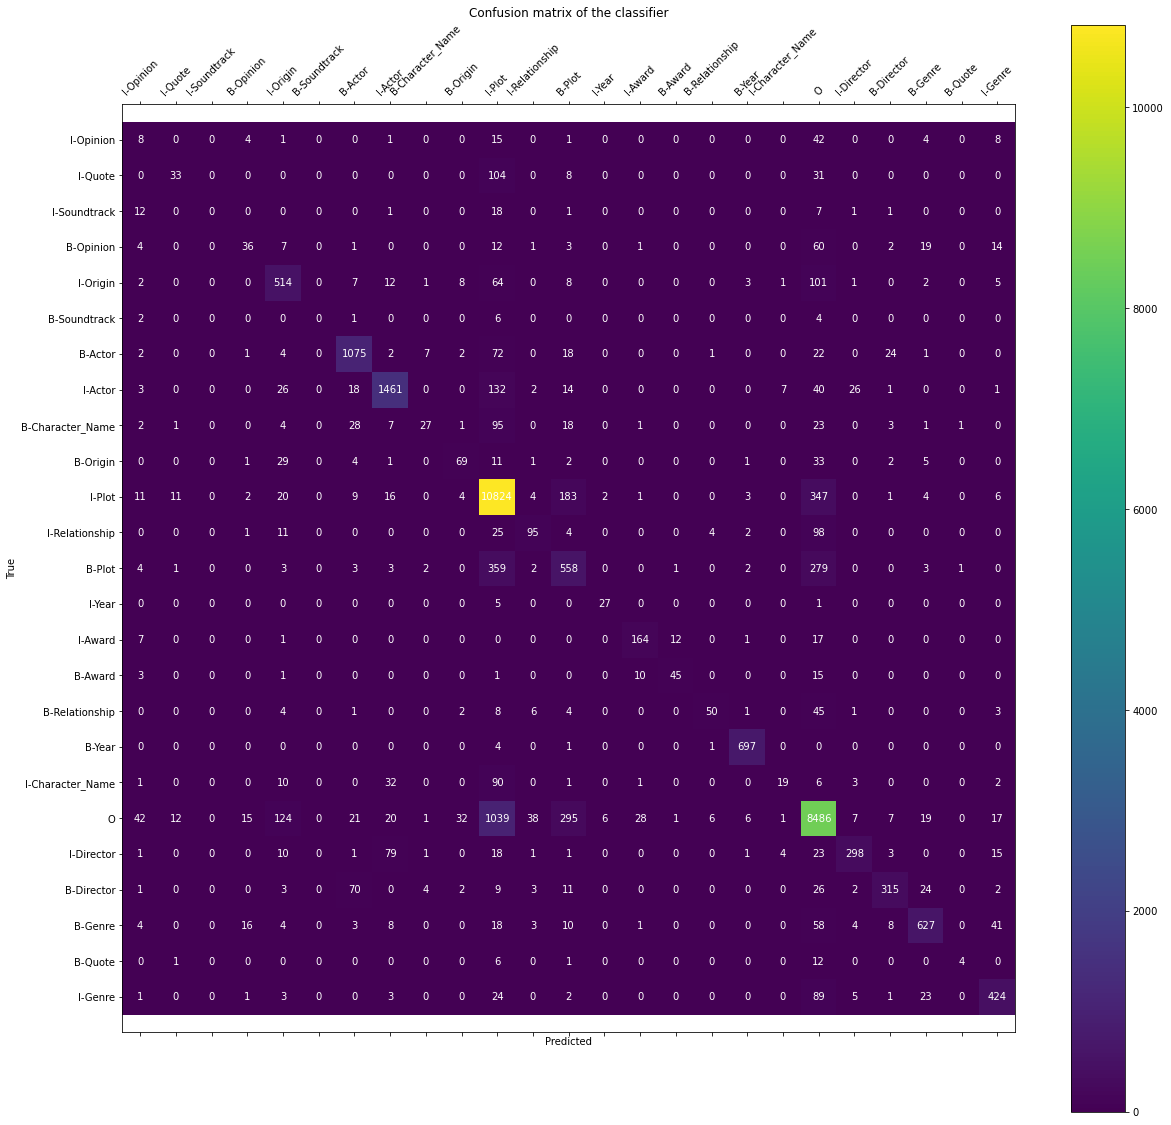

In [39]:
confusion_matrix_heatmap(y_val, preds_val)

### Initial observations

From the heatmap as well as the "support" column in the classification report, it must be noted that several of the classes have a very small observation/token counts versus the rest of the classes. For example,`B-Soundtrack` only has 13 observations. This means that we are dealing with an unbalanced data problem, but in multi-class form as opposed to just the binary case. Based on the initial model, it seems that the low-count classes have the worst class-wise F1 score, save for `I-Year` and `B-Award`.


Later we will be asked to use macro f1 score as the performance metric of choice, wherein the f1 score of each class is simply averaged. This is problematic for unbalanced data because the classes with really low observation counts have the same weight as those with a large number of counts. Since the performance on low-count classes is low, we expect macro-F1 score to be lower compared to the weighted-average f1 score.

## 1.6) Preparation for questions 2 and 3

In order to prepare for questions 2 and 3, which are essentially error analysis questions, we first prepare the necesary codes to generate the classes with the worst precisions and recalls, as well as some functions that print these out in a systematic and easily readable manner.

### 1.6.1) Get the classes with 5 lowest precisions and recalls

In [40]:
#Precision
Lowest_precision = Class_report_Val.sort_values('precision')[0:5]
Lowest_precision_Classes = list(Lowest_precision.index)

print(f'Classes with lowest precision are: {Lowest_precision_Classes}')
display(Lowest_precision)

#Recall
Lowest_recall = Class_report_Val.sort_values('recall')[0:5]
Lowest_recall_Classes = list(Lowest_recall.index)


print(f'Classes with lowest recall are: {Lowest_recall_Classes}')
display(Lowest_recall)

Classes with lowest precision are: ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']


precision    recall  f1-score  support
I-Soundtrack   0.000000  0.000000  0.000000     41.0
B-Soundtrack   0.000000  0.000000  0.000000     13.0
I-Opinion      0.072727  0.095238  0.082474     84.0
B-Opinion      0.467532  0.225000  0.303797    160.0
B-Plot         0.487762  0.457002  0.471882   1221.0

Classes with lowest recall are: ['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'I-Character_Name', 'B-Character_Name']


precision    recall  f1-score  support
B-Soundtrack       0.000000  0.000000  0.000000     13.0
I-Soundtrack       0.000000  0.000000  0.000000     41.0
I-Opinion          0.072727  0.095238  0.082474     84.0
I-Character_Name   0.593750  0.115152  0.192893    165.0
B-Character_Name   0.627907  0.127358  0.211765    212.0

### 1.6.2) Save classes as an array

In [41]:
#Save all classes in an array
Classes = Validation_DF['y'].unique()

print(f"Classes are: {Classes}\nNumber of classes is: {len(Classes)}")

Classes are: ['B-Actor' 'I-Actor' 'O' 'B-Plot' 'I-Plot' 'B-Year' 'B-Award'
 'B-Relationship' 'I-Relationship' 'B-Genre' 'B-Director' 'I-Director'
 'B-Opinion' 'I-Opinion' 'I-Award' 'B-Origin' 'I-Origin' 'I-Genre'
 'B-Character_Name' 'I-Character_Name' 'B-Quote' 'I-Quote' 'I-Year'
 'B-Soundtrack' 'I-Soundtrack']
Number of classes is: 25


### 1.6.3) Define a print tag function that prints tokens, actual tags, and model predictions in a systematic manner

In [42]:
def print_both_tags(list_of_tuples, model, FP_find_tag = "", FN_find_tag = ""):

    '''
    list_of_tuples = list of tuples of (token, actual tag) ex. [(token 1, act tag 1),(token 2, act tag 2)]
    FP_find_tag = tag that you want to indicate as FP. Is counterchecked with the predicted tag.
    FP_find_tag = tag that you want to indicate as FN. Is counterchecked with the actual tag.
    model = what model to use to get the predicted tags.
    '''
    
    #Initialize list of tokens and truths
    tokens = []
    Act_tags = []
    
    for pair in list_of_tuples:
        tokens.append(pair[0]) #token
        Act_tags.append(pair[1]) #Actual
    
    
    #Note how we are running ct.tag on the tokens of the sentence. 
    #This is important because ct.tag might change if a different token list is entered.
    
    pred_tags = [p[1] for p in model.tag(tokens)]
    
    #Print Headers
    print(f"{'Token':15s}{'Truth':20s}{'Prediction':5s}")
    
    for token, Act_tag, pred_tag  in zip(tokens, Act_tags, pred_tags):
        
        Identifier = ""
        
        if pred_tag !=Act_tag: 
            if pred_tag == FP_find_tag:
                Identifier += "--> False Positive"
            if Act_tag == FN_find_tag:
                Identifier += "--> False Negative"    
            
        print(f'{token:15s}{Act_tag:20s}{pred_tag:5s}  {Identifier}')
        
            

In [43]:
list_of_tuples = [("I","B-Relationship"),("Am","I-Relationship"),("A","I-Relationship"),("Potato","I-Relationship")]

print_both_tags(list_of_tuples, model = ct, FP_find_tag = "I-Quote")

Token          Truth               Prediction
I              B-Relationship      I-Quote  --> False Positive
Am             I-Relationship      I-Quote  --> False Positive
A              I-Relationship      I-Quote  --> False Positive
Potato         I-Relationship      I-Quote  --> False Positive


In [44]:
list_of_tuples = [("I","B-Relationship"),("Am","I-Relationship"),("A","I-Relationship"),("Potato","I-Relationship")]

print_both_tags(list_of_tuples, model = ct, FP_find_tag = "I-Quote")

Token          Truth               Prediction
I              B-Relationship      I-Quote  --> False Positive
Am             I-Relationship      I-Quote  --> False Positive
A              I-Relationship      I-Quote  --> False Positive
Potato         I-Relationship      I-Quote  --> False Positive


### 1.6.4) Define a functions for printing out false positive, false negatives, and correct predictions

#### Print function for false positives

In [45]:
#Create a function to print false positives

def Get_False_positive(predictions, Dataframe, model):
    
    '''
    predictions is an array of prediction classes
    truths is an array of truth classes
    Dataframe is the dataframe to be used
    '''


    #Create copy of the input dataframe
    db = Dataframe.copy()


    for prediction in predictions:

        #Create DB of misclassifications
        db_misclass = db[(db['pred'] == prediction) &
                         (db['pred'] != db['y'])
                        ]

        
        #Array containing sentence indices of the misclassified sentences
        sentences_misclass = db_misclass['Sent_index'].unique()


        #---------------------#
        #Print initial findings
        #---------------------#
        print('='*75)
        print(f"False positive of {prediction}")
        
        #Print number of misclassified tokens
        print(f"Number of misclassified tokens {db_misclass.shape[0]}")

        #print number of predictions
        print(f"Number of predictions: {db[db['pred'] == prediction].shape[0]}")

        #Print number of misclassified sentences
        print(f"Number of misclassified sentences: {len(sentences_misclass)}")

        print('='*75+'\n')


        Sent_cnt = 0
        for sentence_index in sentences_misclass:

            #accumulate sentence count
            Sent_cnt += 1

            print(f"False positive of {prediction}")
            print(f"Sentence number: {Sent_cnt}\nSentence Index: {sentence_index}")
            print('\n'+'#' + '='*30 + '#')
            
            
            #Subdf is a df containing the current misclassified sentence 
            subdf = db_misclass[db_misclass['Sent_index'] == sentence_index]

            # print(subdf['text'])
            sentence_tuple = list(subdf['text'])[0] #Get the first cell of 'text' in subdf. This value will be equal for all rows in subdf

            #Print actual and predicted tags
            print_both_tags(list_of_tuples = sentence_tuple, 
                            model = model,
                            FP_find_tag = prediction)
            
            print('='*100)

        #Print end designator
        print('='*100 + '\n' + '='*100 + '\n')   


In [46]:
# #Test Get_False_positive()

# print(f"The tags with the lowest precision are: {Lowest_precision_Classes}\n\n")
# Get_False_positive(predictions =  Lowest_precision_Classes , 
#                    Dataframe = Validation_DF_Full.copy(), 
#                    model = ct)


In [47]:
# #Cross check to see that we are not getting different results

# Validation_DF[Validation_DF["Sent_index"] == 256]

#### Print function for false negatives

In [48]:
#Create a function to print false negatives

def Get_False_negatives(truths, Dataframe, model):
    
    '''
    predictions is an array of prediction classes
    truths is an array of truth classes
    Dataframe is the dataframe to be used
    '''

    #Create copy of the input dataframe
    db = Dataframe.copy()


    for truth in truths:

        #Create DB of misclassifications
        db_misclass = db[(db['y'] == truth) &
                         (db['pred'] != db['y'])
                        ]
        
        #Array containing sentence indices of the misclassified sentences
        sentences_misclass = db_misclass['Sent_index'].unique()

        #---------------------#
        #Print initial findings
        #---------------------#
        print('='*75)
        print(f"False negatives of {truth}")
        
        #Print number of misclassified tokens
        print(f"Number of misclassified tokens {db_misclass.shape[0]}")

        #print number of predictions
        print(f"Number of truths: {db[db['y'] == truth].shape[0]}")

        #Print number of misclassified sentences
        print(f"Number of misclassified sentences: {len(sentences_misclass)}")

        # #Print number of correctly classified sentences
        # print(f"Number of misclass sentences: {len(sentences_correctclass)}")
        print('='*75+'\n')

        Sent_cnt = 0
        for sentence_index in sentences_misclass:

            #accumulate sentence count
            Sent_cnt += 1


            print(f"False negatives of {truth}")
            print(f"Sentence number: {Sent_cnt}\nSentence Index: {sentence_index}")
            print('\n'+'#' + '='*30 + '#')
            
            #Subdf is a df containing the current misclassified sentence 
            subdf = db_misclass[db_misclass['Sent_index'] == sentence_index]

            # print(subdf['text'])
            sentence_tuple = list(subdf['text'])[0] #Get the first cell of 'text' in subdf. This value will be equal for all rows in subdf
            
            
            #Print actual and predicted tags
            print_both_tags(list_of_tuples = sentence_tuple, 
                            model = model, 
                            FN_find_tag = truth)
            
            print('='*100)

        #Print end designator
        print('='*100 + '\n' + '='*100 + '\n')   


In [49]:
# #State a truth vector


# print(f"The tags with the lowest recalls are: {Lowest_recall_Classes}\n\n")

# Get_False_negatives(truths = Lowest_recall_Classes , 
#                    Dataframe = Validation_DF_Full.copy(), 
#                    model = ct)




#### Print function for correct predictions

This function may be needed when assessing false positives, as sometimes you can only ascertain the reasons for wrong predictions by checking the correct predictions.

In [50]:
#Create a function to print correct predictions

def Get_correct_predictions(predictions, Dataframe, model):
    
    '''
    predictions is an array of prediction classes
    truths is an array of truth classes
    Dataframe is the dataframe to be used
    '''


    #Create copy of the input dataframe
    db = Dataframe.copy()


    for prediction in predictions:

        #Create DB of misclassifications
        db_misclass = db[(db['pred'] == prediction) &
                         (db['pred'] == db['y'])
                        ]

        
        #Array containing sentence indices of the misclassified sentences
        sentences_misclass = db_misclass['Sent_index'].unique()

        #---------------------#
        #Print initial findings
        #---------------------#
        print('='*75)
        print(f"Correct classifications of {prediction}")
        
        #Print number of correctly classified tokens
        print(f"Number of correctly classified tokens {db_misclass.shape[0]}")

        #print number of predictions
        print(f"Number of predictions: {db[db['pred'] == prediction].shape[0]}")

        #Print number of correctly classified sentences
        print(f"Number of correctly predicted sentences: {len(sentences_misclass)}")

        print('='*75+'\n')


        Sent_cnt = 0
        for sentence_index in sentences_misclass:

            #accumulate sentence count
            Sent_cnt += 1

            print(f"correct predictions of {prediction}")
            print(f"Sentence number: {Sent_cnt}\nSentence Index: {sentence_index}")
            print('\n'+'#' + '='*30 + '#')
            
            
            #Subdf is a df containing the current misclassified sentence 
            subdf = db_misclass[db_misclass['Sent_index'] == sentence_index]

            # print(subdf['text'])
            sentence_tuple = list(subdf['text'])[0] #Get the first cell of 'text' in subdf. This value will be equal for all rows in subdf

            #Print actual and predicted tags
            print_both_tags(list_of_tuples = sentence_tuple, 
                            model = model)
            
            print('='*100)

        #Print end designator
        print('='*100 + '\n' + '='*100 + '\n')   

In [51]:
# #Test

# print(f"The tags with the lowest precision are: {Lowest_precision_Classes}\n\n")
# Get_correct_predictions(predictions =  Lowest_precision_Classes , 
#                    Dataframe = Validation_DF_Full.copy(), 
#                    model = ct)


# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [52]:
print(f"The tags with the lowest precision are: {Lowest_precision_Classes}\n\n")

The tags with the lowest precision are: ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']




## 2.1) False positives of I-Soundtrack

In [53]:
i = 0
print(f"False positives of {Lowest_precision_Classes[i]}\n")
Get_False_positive(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)


False positives of I-Soundtrack

False positive of I-Soundtrack
Number of misclassified tokens 0
Number of predictions: 0
Number of misclassified sentences: 0




## 2.2) False positives of B-Soundtrack

In [54]:
i = 1
print(f"False positives of {Lowest_precision_Classes[i]}\n")
Get_False_positive(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False positives of B-Soundtrack

False positive of B-Soundtrack
Number of misclassified tokens 0
Number of predictions: 0
Number of misclassified sentences: 0




## 2.3) False positives of I-Opinion

In [55]:
i = 2
print(f"False positives of {Lowest_precision_Classes[i]}\n")
Get_False_positive(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False positives of I-Opinion

False positive of I-Opinion
Number of misclassified tokens 102
Number of predictions: 110
Number of misclassified sentences: 21

False positive of I-Opinion
Sentence number: 1
Sentence Index: 24

#==============================#
Token          Truth               Prediction
play           B-Quote             O      
it             I-Quote             O      
again          I-Quote             O      
sam            I-Quote             O      
is             O                   O      
one            O                   O      
of             O                   O      
the            O                   O      
memorable      O                   O      
quotes         O                   O      
from           O                   O      
this           O                   O      
classic        B-Opinion           B-Opinion  
humphrey       B-Actor             I-Opinion  --> False Positive
bogart         I-Actor             I-Opinion  --> False Positive
ro

## 2.4) False positives of B-Opinion

In [56]:
i = 3
print(f"False positives of {Lowest_precision_Classes[i]}\n")
Get_False_positive(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False positives of B-Opinion

False positive of B-Opinion
Number of misclassified tokens 41
Number of predictions: 77
Number of misclassified sentences: 41

False positive of B-Opinion
Sentence number: 1
Sentence Index: 139

#==============================#
Token          Truth               Prediction
the            O                   O      
sequel         B-Relationship      B-Relationship  
to             O                   O      
a              O                   O      
popular        O                   B-Opinion  --> False Positive
children       B-Genre             B-Genre  
s              O                   O      
movie          O                   O      
about          B-Plot              O      
talking        I-Plot              B-Plot  
motor          I-Plot              I-Plot  
vehicle        I-Plot              I-Plot  
False positive of B-Opinion
Sentence number: 2
Sentence Index: 172

#==============================#
Token          Truth               Predicti

### 2.4) Correct predictions of  B-Opinion

In [57]:
i = 3
print(f"Correct predictions of {Lowest_precision_Classes[i]}\n")
Get_correct_predictions(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

Correct predictions of B-Opinion

Correct classifications of B-Opinion
Number of correctly classified tokens 36
Number of predictions: 77
Number of correctly predicted sentences: 36

correct predictions of B-Opinion
Sentence number: 1
Sentence Index: 24

#==============================#
Token          Truth               Prediction
play           B-Quote             O      
it             I-Quote             O      
again          I-Quote             O      
sam            I-Quote             O      
is             O                   O      
one            O                   O      
of             O                   O      
the            O                   O      
memorable      O                   O      
quotes         O                   O      
from           O                   O      
this           O                   O      
classic        B-Opinion           B-Opinion  
humphrey       B-Actor             I-Opinion  
bogart         I-Actor             I-Opinion  
romance  

## 2.5) False positives of B-Plot

In [58]:
i = 4
print(f"False positives of {Lowest_precision_Classes[i]}\n")
Get_False_positive(predictions =  [Lowest_precision_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False positives of B-Plot

False positive of B-Plot
Number of misclassified tokens 586
Number of predictions: 1144
Number of misclassified sentences: 585

False positive of B-Plot
Sentence number: 1
Sentence Index: 1

#==============================#
Token          Truth               Prediction
on             B-Plot              O      
a              I-Plot              B-Plot  --> False Positive
vacation       I-Plot              I-Plot  
in             I-Plot              I-Plot  
paris          I-Plot              I-Plot  
one            I-Plot              I-Plot  
of             I-Plot              I-Plot  
three          I-Plot              I-Plot  
travelers      I-Plot              I-Plot  
is             I-Plot              I-Plot  
mistaken       I-Plot              I-Plot  
for            I-Plot              I-Plot  
a              I-Plot              I-Plot  
british        I-Plot              I-Plot  
heiress        I-Plot              I-Plot  
False positive of B-Plot
S

## Observations

### 1) False positives of I-Soundtrack

The initial model made no predictions for this class. hence why its precision is zero. We will need to check its false negatives sentences in order to make any kind of observation.


### 2) False positives of B-Soundtrack
The initial model made no predictions for this class. hence why its precision is zero. We will need to check its false negatives sentences in order to make any kind of observation.

### 3) False positives of I-Opinion

The most common problem for this class is that the model cannot tell when an opinion is continued. For example, in sentence indices 24 and 156 the model mistakenly thinks that an opinion is continued when it is actually just one `B-Opinion` token. Moreover, in sentence index 641 the model thinks that the phrase "short lived love interest" is an opinion when it is not, same with sentence index 662 and the phrase "the most famous musician meatloaf". 

Another thing to note is that a number of the misclassified words occur after modifiers like "classic" in sentence indices 24, "popular" in sentence index 1268, and "famous" in 1390. Perhaps the addition of back-window POS tag can help the model distinguish when quotes are continued. Moreover, it must be noted that this class always occurs after a `B-Opinion`, so perhaps improving model performance on that class can help improve the performance on this one.


### 4) False positives of B-Opinion


This class has a similar problem to the previous one, as the model has trouble telling when an opinion actually begins or not. For example, in sentence index 172 the model thinks that the word "classic" is the start of an opinion when it is actually just used to describe the genre of a movie (i.e. it's a `B-Genre`). Moreover, most of the words misclassified as this class are also modifiers. Some examples include the aforementioned "classic" in sentence indices 172, 214, 232, 239, 240 and more , "short" in sentence index 641, "famous" in sentence index "662", and "villainous" in sentence index 256. "Classic" in itself is the most misclassified case, as it is shared among classes. For example, in sentence index 96 it is a `B-Opinion`, but in 172 it is a `B-Genre`.

One potential way to fix these issues is to add POS-tags and possibly backward and forward-window features to the model. Since the initial model only has word usage as a feature, the addition of these variables add more granularity, and hence may help the model better distinguish common word usages among classes. A simple example of this is that perhaps the POS tags of the word "classic" in opinions are different to that in genres, and hence the model can leverage that new information. On the other hand, the addition of window variables may help the model tell when opinions actually start or occur, especially in conjuction with POS tags.



### 5) False positives of B-Plot

From the misclassified sentences, it seems that the main issue with predictions for this class is that model either has trouble finding when a plot phrase begins, when it ends, or it mistakenly thinks a sentence has one when it doesn't. as mentioned earlier, one way to address this is to add backward a forward-window features to the model. This is so the model predicts a particular token based on that token's information and the information of the ones beside it.

Moreover, a number of the misclassifications are for determiners such as "a" in sentence indices 109, 99 & 93 and "the" in sentence indices 113 and 118. Perhaps these can be mitigated through the use of POS tags and window features.

Finally, there are a few cases wherein the model mispredicts people as `B-Plots`, such as in sentence index 1027 where the model mistakenly tags a `B-Director`. Perhaps improving the performances on these classes can help improve the precision on this one. One example could be the use of a gazetteer for directors.

# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [59]:
print(f"The tags with the lowest recalls are: {Lowest_recall_Classes}\n\n")

The tags with the lowest recalls are: ['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'I-Character_Name', 'B-Character_Name']




## 3.1) False negatives of B-Soundtrack

In [60]:
i = 0
Get_False_negatives(truths = [Lowest_recall_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False negatives of B-Soundtrack
Number of misclassified tokens 13
Number of truths: 13
Number of misclassified sentences: 13

False negatives of B-Soundtrack
Sentence number: 1
Sentence Index: 179

#==============================#
Token          Truth               Prediction
this           O                   O      
1990           B-Year              B-Year  
s              I-Year              I-Year  
animated       B-Genre             B-Genre  
feature        I-Genre             O      
taught         O                   O      
us             O                   O      
the            O                   O      
song           O                   O      
hakuna         B-Soundtrack        B-Actor  --> False Negative
matata         I-Soundtrack        I-Actor  
which          O                   O      
championed     O                   O      
a              O                   B-Plot  
down           O                   I-Plot  
to             O                   I-Plot  
earth 

## 3.2) False negatives of I-Soundtrack

In [61]:
i = 1
Get_False_negatives(truths = [Lowest_recall_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False negatives of I-Soundtrack
Number of misclassified tokens 41
Number of truths: 41
Number of misclassified sentences: 13

False negatives of I-Soundtrack
Sentence number: 1
Sentence Index: 179

#==============================#
Token          Truth               Prediction
this           O                   O      
1990           B-Year              B-Year  
s              I-Year              I-Year  
animated       B-Genre             B-Genre  
feature        I-Genre             O      
taught         O                   O      
us             O                   O      
the            O                   O      
song           O                   O      
hakuna         B-Soundtrack        B-Actor  
matata         I-Soundtrack        I-Actor  --> False Negative
which          O                   O      
championed     O                   O      
a              O                   B-Plot  
down           O                   I-Plot  
to             O                   I-Plot  
earth 

## 3.3) False negatives of I-Opinion

In [62]:
i = 2
Get_False_negatives(truths = [Lowest_recall_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False negatives of I-Opinion
Number of misclassified tokens 76
Number of truths: 84
Number of misclassified sentences: 41

False negatives of I-Opinion
Sentence number: 1
Sentence Index: 5

#==============================#
Token          Truth               Prediction
one            O                   O      
of             O                   O      
the            O                   O      
most           B-Opinion           O      
memorable      I-Opinion           O      --> False Negative
scenes         I-Opinion           O      --> False Negative
from           O                   O      
this           O                   O      
film           O                   O      
involve        O                   O      
a              B-Plot              B-Plot  
boy            I-Plot              I-Plot  
riding         I-Plot              I-Plot  
his            I-Plot              I-Plot  
bike           I-Plot              I-Plot  
through        I-Plot              I-Plot  
t

## 3.4) False negatives of I-Character_Name

In [63]:
i = 3
Get_False_negatives(truths = [Lowest_recall_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False negatives of I-Character_Name
Number of misclassified tokens 146
Number of truths: 165
Number of misclassified sentences: 104

False negatives of I-Character_Name
Sentence number: 1
Sentence Index: 15

#==============================#
Token          Truth               Prediction
paul           B-Actor             B-Actor  
newman         I-Actor             I-Actor  
stars          O                   O      
as             O                   O      
rocky          B-Character_Name    B-Actor  
graziano       I-Character_Name    I-Actor  --> False Negative
in             O                   O      
this           O                   O      
biographical   B-Genre             B-Genre  
drama          I-Genre             I-Genre  
about          O                   O      
a              B-Plot              B-Plot  
criminal       I-Plot              I-Plot  
turned         I-Plot              I-Plot  
boxer          I-Plot              I-Plot  
False negatives of I-Character_Nam

## 3.5) False negatives of B-Character_Name

In [64]:
i = 4
Get_False_negatives(truths = [Lowest_recall_Classes[i]] , 
                   Dataframe = Validation_DF_Full.copy(), 
                   model = ct)

False negatives of B-Character_Name
Number of misclassified tokens 185
Number of truths: 212
Number of misclassified sentences: 150

False negatives of B-Character_Name
Sentence number: 1
Sentence Index: 15

#==============================#
Token          Truth               Prediction
paul           B-Actor             B-Actor  
newman         I-Actor             I-Actor  
stars          O                   O      
as             O                   O      
rocky          B-Character_Name    B-Actor  --> False Negative
graziano       I-Character_Name    I-Actor  
in             O                   O      
this           O                   O      
biographical   B-Genre             B-Genre  
drama          I-Genre             I-Genre  
about          O                   O      
a              B-Plot              B-Plot  
criminal       I-Plot              I-Plot  
turned         I-Plot              I-Plot  
boxer          I-Plot              I-Plot  
False negatives of B-Character_Nam

## Observation

### 1) False negatives of B-Soundtrack

This class was most commonly misclassified as `I-Plot`, though there were some cases wherein tokens were misclassified as `I-Opinion`, `B-Actor` and `O`. A number of the sentences also have the phrases "the song" or "the" + *modifier* + "song", such as in sentence index 232 where the phrase "the *classic* song" precedes the song title "puttin on the ritz". Because of this, the addition of back-window features may help the model better predict this class. Moreover, a gazetteer of song names may also be helpful, however the implementation might be a bit tricky because we don't necessarily know how many tokens a particular song title can contain.

Another interesting thing to note is that `Soundtrack` tokens need not contain the titles of songs. Examples of these are in sentence indices 1113, 1233 and 995, where the `Soundtrack` tokens simply refer to the music of a movie rather than a particular song. Moreover, these tokens can also contain the names of composers, such as "daft Punk" in index 1034 and "irving berlin" in index 995. Thus, gazetteer of composers may also be helpful, and the implementation would be a bit similar because names don't usually have a very long token range (e.g. they usually are just 2 tokens: *first name* & *last name*). 


### 2) False negatives of I-Soundtrack

All observations for `B-Soundtrack` also apply to this class. This is because all `B-Soundtrack` sentences also contain `I-Soundtrack` tokens, and in fact their misclassified sentence is count is also the same (misclass. sentences = 13). Moreover, since this class always comes after a `B-Soundtrack` token, improving the performance on the that class may also help improve the predictions on this one.



### 3) False negatives of I-Opinion

A number of the tokens in this class are modifiers, such as the tokens "most famous" in index 302, "funny" in index 403, and "hit" in index 20. Thus, the addition of POS tags and backward-window features may improve the model's predictions on this class. Moreover, they always happen after a `B-Opinion` token, so improving model performance on that class may help improve the performance on this one.



### 4) False negatives of I-Character_Name

The main issues with this class is that the model has a hard time recognizing when `Character` names are used in a sentence, and whether or not they are characters or actual people. An example of the first is in sentence index 143, where the name "t e laurence" is mistaken as a `Plot`. This was most likely because the name came after the word "story", which the model also mislabeled as a "B-Plot". Note that the current model was primarily trained on word usages, and hence the word "story" was probably common for `Plot` tokens, hence the mispredictions here. One way to circumvent this would be to add POS and backward and forward-window features, as the added granularity may help the model distinguish whe character names actually occur. For example, perhaps the model can learn that the usage of the phrase "story of" can lead to a character name, as in index 143.

An example of the second problem is in index 128, where the tokens "willie nelson" are mistakenly predicted as `Actor` tokens.  One possible way to prevent this is to increase the precision of the `Actor` classes. One way to do this would be to make a gazetteer for actors. Another more complex strategy would be to make a gazetteer for movie character names, but this might be harder to collect.


Another interesting to note is that words describing a single `B-Character_Name` can also be `I-Character_Names`. For example, in index 18 the entity "perseus" was correctly predicted as a `B-Character_Name` but the following tokens in the descriptive phrase "mortal son of zeus" were mislabeled as `Plots` instead of `I-Character_Names`. Perhaps POS tags can help circumvent this.

Finally, this class always occurs after a `B-Character_Name`so improving the predictions on that class may improve the predictions on this one.



### 5) False negatives of B-Character_Name

The observations and suggestions for `I-Character` name also apply to this one, as both classes are connected. The main difference is that `B-Character_Name` can be single tokens, as in index 1437 where the tokens "queequeg" and "ishmael" are misclassified as `O` tokens. This was most likely because these tokens didn't actually appear in the training set and hence the model just labeled as 'O' (recall that the current model is mostly trained on just word usages, and that those particular names look like very oblique names that are probably specific to just that sentence). The addition of window features and POS tags may help, but the best solution for this case may be a gazetteer for character names.




## Conclusions on initial error analysis

It seems that we can yield improvements on most of the 10 classes by introducing POS tags and window variables (e.g. 1 word before, POS tag of 2 words after, etc)  as features. Moreover, some of the class could benefit from the use of gazetteers, but it has to be noted that these gazetteers could also affect the model's performance on all the other classes. Moreover, the use of gazetteers in this scenario may be difficult, especially in terms of computational run-time.

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

## 4.1) Initialize the POS tagger and modify the existing pre-process function

The first step to answering this question is to initialize the POS tagger and see what are the inputs and outputs. From the example below, it takes a sentence list as an input and attaches a POS tag to each token in the sentence. After which, it then ouputs a list of tuples, where the first element of each tuple is a token while the second is its corresponding POS tag. Moreover, we need to make sure that we run the POS tagger on sentences and not individual tokens.


In [65]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]

words1 = ["john"]
words2 = ["john", "likes"]
words3 = ["john", "mary"]
words4 = ["john", "bill", "and", "Mary"]


print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [66]:
#more testing
words1 = ["what","is","the","movie","I","like"]
words2 = ["where","is","the","place","I","like"]
words3 = ["who","is","the","actor","in","the","movie"]
words4 = ["who","is","the","actor","in","the","movie"]


print(posttagger.tag(words1))
print(posttagger.tag(words2))
print(posttagger.tag(words3))

[('what', 'WP'), ('is', 'VBZ'), ('the', 'DT'), ('movie', 'NN'), ('I', 'NN'), ('like', 'IN')]
[('where', 'WRB'), ('is', 'VBZ'), ('the', 'DT'), ('place', 'NN'), ('I', 'NN'), ('like', 'IN')]
[('who', 'WP'), ('is', 'VBZ'), ('the', 'DT'), ('actor', 'NN'), ('in', 'IN'), ('the', 'DT'), ('movie', 'NN')]


Once we have initialized and tested the tagger on a dummy example, the next step is to apply it to the pre-processing function. Note here that we apply the POS tagger to a sentence which is in the form of a vector of words. Once the POS tagger is run, we attach each POS tag to its corresponding token in the form *token@POS*.

In [67]:
def preProcess_modified(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    
    Sentence = [word_tuple[0] for word_tuple in example] #vector of words in the sentence
    POS_Tags = posttagger.tag(Sentence) # run the POS tagger on the sentence
    
    
    Words_POS = [word_tuple[0] + "@"+ word_tuple[1] for word_tuple in POS_Tags]
    
    
    
    Tags = [word_tuple[1] for word_tuple in example] #vector of NER Tags

    Words_POS_Tags = list(zip(Words_POS,Tags))
    
    
    preprocessed_example = Words_POS_Tags
    
    return preprocessed_example

preProcess_modified(training_data[0])

[('steve@PRPVBP', 'B-Actor'),
 ('mcqueen@VBN', 'I-Actor'),
 ('provided@VBN', 'O'),
 ('a@DT', 'O'),
 ('thrilling@NN', 'B-Plot'),
 ('motorcycle@NN', 'I-Plot'),
 ('chase@NN', 'I-Plot'),
 ('in@IN', 'I-Plot'),
 ('this@DT', 'I-Plot'),
 ('greatest@JJS', 'B-Opinion'),
 ('of@IN', 'I-Opinion'),
 ('all@DT', 'I-Opinion'),
 ('ww@NNP', 'B-Plot'),
 ('2@NNP', 'I-Plot'),
 ('prison@NNP', 'I-Plot'),
 ('escape@NN', 'I-Plot'),
 ('movies@NNS', 'I-Plot')]

As stated above, note that we have concatenated the POS tag to the token, separating them with the string *@*. We will separate the within the `get_feature` function later on.

## 4.2) Create token extraction and word extraction functions

Use `split` to get the token and POS tag based on the character `@`. If for some reason the `@` character doesn't exist, then return a blank.

In [68]:
def Get_POS(word_POS):
    '''
    word_POS is a string with format word@POS_tag
    '''
    
    elem_list = word_POS.split('@')
    if len(elem_list) >= 2:
        return elem_list[1] #second element will always be the POS tag
    else:
        return ''
    
print(Get_POS('movies@NNS'))

print(Get_POS('Word@'))

print(Get_POS('Word'))

NNS




In [69]:
def Get_Word(word_POS):
    '''
    word_POS is a string with format word@POS_tag
    '''

    elem_list = word_POS.split('@')

    return elem_list[0]

print(Get_Word('movies@NNS'))
print(Get_Word('movies@'))
print(Get_Word('movies'))

movies
movies
movies


In [70]:
#test words with no POS tags
display( training_data[0])
[Get_POS(tuple[0]) for tuple in training_data[0]]

[('steve', 'B-Actor'),
 ('mcqueen', 'I-Actor'),
 ('provided', 'O'),
 ('a', 'O'),
 ('thrilling', 'B-Plot'),
 ('motorcycle', 'I-Plot'),
 ('chase', 'I-Plot'),
 ('in', 'I-Plot'),
 ('this', 'I-Plot'),
 ('greatest', 'B-Opinion'),
 ('of', 'I-Opinion'),
 ('all', 'I-Opinion'),
 ('ww', 'B-Plot'),
 ('2', 'I-Plot'),
 ('prison', 'I-Plot'),
 ('escape', 'I-Plot'),
 ('movies', 'I-Plot')]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

## 4.3) New get_feature function

In [71]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_wPOS(tokens_POS, idx):
    """
    
    Inputs:
    Token_POS = list of words and POS tags in the form [word1@POS1, word2@POS2, etc.]
    idx = index
    
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """    
    
    tokens = [Get_Word(token_pos) for token_pos in tokens_POS]
    POS_tags = [Get_POS(token_pos) for token_pos in tokens_POS]
    
    
    # print(f"Initial sentence is: {tokens_POS}")
    # print(f"Tokens are: {tokens}\n")
    # print(f"POS tags are: {POS_tags}\n")

    
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    
     # Capitalization
    if token[0].isupper():
         feature_list.append("CAPITALIZATION")

     # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

     # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

     # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
        
    #POS Tag
    #get the pos tags chosen token
    feature_list.append("POS_" + POS_tags[idx])
    
    #Word
    feature_list.append("WORD_" + token)
    
    
    # #Word and POS tag together
    # feature_list.append(token + "_" + POS_tags[idx])
    
     #print(feature_list)
    
    return feature_list

In [72]:
#Test an example

example = [Tuple[0] for Tuple in preProcess_modified(training_data[0])]

print(f"Initial example is:\n{example}\n\n")

for i in range(len(example)):
    
    print(f"Feature vector for index {i}, {example[i]}: {get_features_wPOS(example, i)}")

Initial example is:
['steve@PRPVBP', 'mcqueen@VBN', 'provided@VBN', 'a@DT', 'thrilling@NN', 'motorcycle@NN', 'chase@NN', 'in@IN', 'this@DT', 'greatest@JJS', 'of@IN', 'all@DT', 'ww@NNP', '2@NNP', 'prison@NNP', 'escape@NN', 'movies@NNS']


Feature vector for index 0, steve@PRPVBP: ['SUF_e', 'SUF_ve', 'SUF_eve', 'POS_PRPVBP', 'WORD_steve']
Feature vector for index 1, mcqueen@VBN: ['SUF_n', 'SUF_en', 'SUF_een', 'POS_VBN', 'WORD_mcqueen']
Feature vector for index 2, provided@VBN: ['SUF_d', 'SUF_ed', 'SUF_ded', 'POS_VBN', 'WORD_provided']
Feature vector for index 3, a@DT: ['POS_DT', 'WORD_a']
Feature vector for index 4, thrilling@NN: ['SUF_g', 'SUF_ng', 'SUF_ing', 'POS_NN', 'WORD_thrilling']
Feature vector for index 5, motorcycle@NN: ['SUF_e', 'SUF_le', 'SUF_cle', 'POS_NN', 'WORD_motorcycle']
Feature vector for index 6, chase@NN: ['SUF_e', 'SUF_se', 'SUF_ase', 'POS_NN', 'WORD_chase']
Feature vector for index 7, in@IN: ['SUF_n', 'POS_IN', 'WORD_in']
Feature vector for index 8, this@DT: ['SUF_

Note that POS tags are now additional features in the feature vector.

Now that we have modified the `preprocessing` and  `get_feature` functions, it's now time to retrain our model. Note that we need to follow the following steps:
1. Preprocess our datasets (train and validation sets)
2. Train the model, making sure that we use the newly pre-processed datasets and the new `get_features` function.
3. Test and validate the newly trained model using the validation set
4. Compare results with the initial model

## 4.4) Preprocess the existing train and validation set

In [73]:
training_data_wPOS = [preProcess_modified(example) for example in train_data]
validation_data_wPOS = [preProcess_modified(example) for example in validation_data]

In [74]:
training_data_wPOS[0:10]

[[('steve@PRPVBP', 'B-Actor'),
  ('mcqueen@VBN', 'I-Actor'),
  ('provided@VBN', 'O'),
  ('a@DT', 'O'),
  ('thrilling@NN', 'B-Plot'),
  ('motorcycle@NN', 'I-Plot'),
  ('chase@NN', 'I-Plot'),
  ('in@IN', 'I-Plot'),
  ('this@DT', 'I-Plot'),
  ('greatest@JJS', 'B-Opinion'),
  ('of@IN', 'I-Opinion'),
  ('all@DT', 'I-Opinion'),
  ('ww@NNP', 'B-Plot'),
  ('2@NNP', 'I-Plot'),
  ('prison@NNP', 'I-Plot'),
  ('escape@NN', 'I-Plot'),
  ('movies@NNS', 'I-Plot')],
 [('liza@NNP', 'B-Actor'),
  ('minnelli@NNP', 'I-Actor'),
  ('and@CC', 'O'),
  ('joel@NNP', 'B-Actor'),
  ('gray@NNP', 'I-Actor'),
  ('won@NNP', 'B-Award'),
  ('oscars@NNS', 'I-Award'),
  ('for@IN', 'O'),
  ('their@PRP$', 'O'),
  ('roles@NNS', 'O'),
  ('in@IN', 'O'),
  ('this@DT', 'O'),
  ('1972@NN', 'B-Year'),
  ('movie@NN', 'O'),
  ('that@WDT', 'B-Plot'),
  ('follows@VBZ', 'I-Plot'),
  ('nightclub@NN', 'I-Plot'),
  ('entertainers@NNS', 'I-Plot'),
  ('in@IN', 'I-Plot'),
  ('berlin@NNP', 'I-Plot'),
  ('as@IN', 'I-Plot'),
  ('the@DT', 'I-Pl

## 4.5) Train CRF with POS tag

In [75]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_wPOS_CourseworkQ4.tagger"  # path to the tagger- it will save/access the model from here
ct_POS = CRFTagger(feature_func=get_features_wPOS)  # initialize tagger with get_features function

print("training tagger...")

#Set train data and tagger path
ct_POS.train(training_data_wPOS, TAGGER_PATH)
print("done")

training tagger...
done


In [76]:
# load tagger from saved file
ct_POS = CRFTagger(feature_func=get_features_wPOS)  # initialize tagger
ct_POS.set_model_file(TAGGER_PATH)  # load model from file

In [77]:
print_most_predictive_state_features(ct_POS._tagger.info().state_features.items())

5.629087 B-Year   HAS_NUM
4.144185 I-Year   WORD_s
3.737654 B-Genre  WORD_animated
2.845034 B-Genre  WORD_action
2.804510 B-Genre  WORD_thriller
2.559647 B-Relationship SUF_uel
2.546358 B-Award  WORD_oscar
2.521965 B-Opinion WORD_blockbuster
2.468648 I-Genre  WORD_animated
2.450255 I-Genre  WORD_fiction
2.426618 B-Award  SUF_car
2.420485 B-Actor  WORD_cher
2.353845 B-Genre  WORD_animation
2.338838 B-Actor  WORD_fred
2.338206 B-Genre  WORD_slasher
2.325494 B-Genre  WORD_comedy
2.309102 B-Genre  WORD_war
2.298586 I-Genre  WORD_thriller
2.289748 B-Genre  WORD_horror
2.288792 B-Director WORD_disney
2.173788 I-Actor  WORD_cage
2.147929 B-Opinion WORD_masterpiece
2.137550 B-Director SUF_xar
2.137550 B-Director WORD_pixar
2.126638 B-Genre  WORD_musical
2.121748 B-Relationship WORD_remake
2.121208 B-Relationship WORD_sequel
2.112327 B-Genre  WORD_documentary
2.106541 B-Quote  WORD_i
2.103125 B-Origin WORD_adapted
2.101927 I-Genre  WORD_war
2.057882 B-Character_Name WORD_dave
2.055626 B-Award  

## 4.6) Performance of updated CRF model on the validation set

In [78]:
#Create dataframes of the validation set

#Token Level DF
Validation_DF = Make_Token_Dataframe(model = ct_POS, data = validation_data_wPOS)

#Sentence level DF
Validation_Sent_DF = Make_Sentence_Dataframe(data = validation_data_wPOS)

Validation_DF_Full = Make_Full_Dataframe(DF = Validation_DF, Sent_DF = Validation_Sent_DF)

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


In [79]:
# Output the classification report (which you should save each time for comparing your models)

y_val = Validation_DF['y']
preds_val = Validation_DF['pred']

#Save as DF
Class_report_Val_POS = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Val_POS_str = classification_report(y_val, preds_val) #

Class_report_summaries_POS = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(f"Classification report of the CRF with POS tags as features validation set\n{'='*100}\n{Class_report_Val_POS_str}")
print(Class_report_summaries_POS)  # print out accurate macro score

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metr

Classification report of the CRF with POS tags as features validation set
                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.52      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       1

C:\Users\msolu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# Classification report of the CRF with POS tags as features validation set
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.86      0.88      0.87      1231
#          B-Award       0.78      0.61      0.69        75
# B-Character_Name       0.56      0.13      0.21       212
#       B-Director       0.85      0.69      0.76       472
#          B-Genre       0.86      0.78      0.82       805
#        B-Opinion       0.52      0.26      0.34       160
#         B-Origin       0.53      0.42      0.47       159
#           B-Plot       0.49      0.46      0.47      1221
#          B-Quote       0.57      0.17      0.26        24
#   B-Relationship       0.84      0.50      0.63       125
#     B-Soundtrack       0.00      0.00      0.00        13
#           B-Year       0.97      0.99      0.98       703
#          I-Actor       0.88      0.88      0.88      1731
#          I-Award       0.79      0.79      0.79       202
# I-Character_Name       0.53      0.15      0.24       165
#       I-Director       0.86      0.68      0.76       456
#          I-Genre       0.79      0.75      0.77       576
#        I-Opinion       0.09      0.10      0.09        84
#         I-Origin       0.64      0.70      0.67       729
#           I-Plot       0.84      0.94      0.89     11448
#          I-Quote       0.59      0.19      0.28       176
#   I-Relationship       0.57      0.44      0.50       240
#     I-Soundtrack       0.00      0.00      0.00        41
#           I-Year       0.77      0.82      0.79        33
#                O       0.87      0.83      0.85     10223

#         accuracy                           0.83     31304
#        macro avg       0.64      0.53      0.56     31304
#     weighted avg       0.82      0.83      0.82     31304

# (0.6425708430672527, 0.5259705812799771, 0.5603252090345863, None)

## 4.7) Compare with previous results

As compared with the results of the initial model, the addition of POS tags as features yield a very slight increase to the macro average F1 score, most likely due to the slight increase in macro-average recall. Overall though, the performance did not change much, so there is definitely a need to do further feature selection.

In [80]:
print(f"Classification report of the initial CRF\n{'='*100}\n{Class_report_Val_str}")
print(Class_report_summaries)  # print out accurate macro score

Classification report of the initial CRF
                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.13      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86   

## 4.8) Error Analysis

### Check the tags with the previous 5 lowest precision classes

From the results below, note that the precision of the model increased slightly for `B-Opinion`, `I-Opinion`, and `B-Plot`. This means that the addition of POS tags helped the model perform slightly better on these classes, as alluded to in the prior error analysis. However, the model still made no predictions for `B-Soundtrack` and `I-Soundtrack`. Perhaps the addition of backward and forward window features will help improve the performance on these two.

In [81]:
print('Results of POS model (5 lowest precisions)')
display(Class_report_Val_POS.loc[Lowest_precision_Classes])
print('Results of previous model (5 lowest precisions)')
display(Class_report_Val.loc[Lowest_precision_Classes])

Results of POS model (5 lowest precisions)


precision    recall  f1-score  support
I-Soundtrack   0.000000  0.000000  0.000000     41.0
B-Soundtrack   0.000000  0.000000  0.000000     13.0
I-Opinion      0.090909  0.095238  0.093023     84.0
B-Opinion      0.518987  0.256250  0.343096    160.0
B-Plot         0.492485  0.456183  0.473639   1221.0

Results of previous model (5 lowest precisions)


precision    recall  f1-score  support
I-Soundtrack   0.000000  0.000000  0.000000     41.0
B-Soundtrack   0.000000  0.000000  0.000000     13.0
I-Opinion      0.072727  0.095238  0.082474     84.0
B-Opinion      0.467532  0.225000  0.303797    160.0
B-Plot         0.487762  0.457002  0.471882   1221.0

### Check the tags with the previous 5 lowest recall classes

Only `I-Character_Name` got an increase in recall score. This means that the addition of POS tags alone was not enough for the model to improve its performance on the remaining 4 classes. We will add backwindow and forward window features and look back at this table later on.

In [82]:
print('Results of POS model (5 lowest recalls)')
display(Class_report_Val_POS.loc[Lowest_recall_Classes])
print('Results of previous model (5 lowest recalls)')
display(Class_report_Val.loc[Lowest_recall_Classes])

Results of POS model (5 lowest recalls)


precision    recall  f1-score  support
B-Soundtrack       0.000000  0.000000  0.000000     13.0
I-Soundtrack       0.000000  0.000000  0.000000     41.0
I-Opinion          0.090909  0.095238  0.093023     84.0
I-Character_Name   0.531915  0.151515  0.235849    165.0
B-Character_Name   0.562500  0.127358  0.207692    212.0

Results of previous model (5 lowest recalls)


precision    recall  f1-score  support
B-Soundtrack       0.000000  0.000000  0.000000     13.0
I-Soundtrack       0.000000  0.000000  0.000000     41.0
I-Opinion          0.072727  0.095238  0.082474     84.0
I-Character_Name   0.593750  0.115152  0.192893    165.0
B-Character_Name   0.627907  0.127358  0.211765    212.0

### Check new lowest precision and recall classes

No classes graduated from the two lists.

In [83]:
#Precision
Lowest_precision_POS = Class_report_Val_POS.sort_values('precision')[0:5]
Lowest_precision_Classes_POS = list(Lowest_precision.index)

print(f'Classes with lowest precision are: {Lowest_precision_Classes_POS}')
display(Lowest_precision_POS)

#Recall
Lowest_recall_POS = Class_report_Val_POS.sort_values('recall')[0:5]
Lowest_recall_Classes_POS = list(Lowest_recall.index)


print(f'Classes with lowest recall are: {Lowest_recall_Classes_POS}')
display(Lowest_recall_POS)

Classes with lowest precision are: ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']


precision    recall  f1-score  support
I-Soundtrack   0.000000  0.000000  0.000000     41.0
B-Soundtrack   0.000000  0.000000  0.000000     13.0
I-Opinion      0.090909  0.095238  0.093023     84.0
B-Plot         0.492485  0.456183  0.473639   1221.0
B-Opinion      0.518987  0.256250  0.343096    160.0

Classes with lowest recall are: ['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'I-Character_Name', 'B-Character_Name']


precision    recall  f1-score  support
B-Soundtrack       0.000000  0.000000  0.000000     13.0
I-Soundtrack       0.000000  0.000000  0.000000     41.0
I-Opinion          0.090909  0.095238  0.093023     84.0
B-Character_Name   0.562500  0.127358  0.207692    212.0
I-Character_Name   0.531915  0.151515  0.235849    165.0

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then **re-train** the model on **ALL the training data** and print the classification report for the **original test data** (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

## 5.1 Overview of modeling methodology 

As with what was stated in the question, the end goal is to use error analysis, feature selection, and hyperparameter tuning to improve the macro F1 score of the model. In order to do this, we introduce the following workflow:

1. Do feature selection and implement in the `get_features` function
2. Pre-process the data if needed
3. Train the model, making sure that we use the newly pre-processed datasets and the new `get_features` function.
4. Check the most predictive variables
5. Check the performance of the new model on the training set
6. Check the performance of the new model on the validation set
7. Error analysis

Note that the reason why we also check the performance of the training set is because we want to check if the current model is overfitting. If it is overfitting, then we can improve model generalization either through feature removal or through regularization via the c1 and c2 parameters. However, if it is underfitting, meaning both training and validation macro f1 scores are low, then there is a need for more feature selection/engineering.

Moreover, to save on time and document length, only the first model iteration will contain all steps. For succeeding iterations, only the most relevant steps will be recorded.

Once the final features have been decided on, we will run a function from scikit optimize (*skopt*) in order to get the best hyperparameters. This will be a lengthy process, but it should give us some performance gains.

## A) Model iteration 1


For the first and succeeding model iterations prior to hyperparameter tuning, we set the hyperparameter `feature.minfreq` to 5. This functions like a minimum document frequency, where each feature needs to appear at least 5 times to be used by the model. The motivation behind this decision is to temper dimensionality and to remove possibly irrelevant features from the onset without the need to alter the `get_features` function. Moreover, this will still be tuned after we have decided on the features. 


As for the model features, we now introduce the use of the following:

1. Prefixes (adjustable length)
2. Suffixes (adjustable length)
3. Backward-window features (adjustable length)
3. Forward-window features (adjustable length)


backward and forward window are just the POS tag, word, suffix, prefix, and etc. of the nth word before or after the current word. For example, if `window_prev` = 3 then we get the features of the current word and the 3 words before it. There will be an illustration of this later on. We also remove capitalization and punctuation from the get_feature function, as the input sentence are pre-processed and do not contain these. 


For now set `pref_length` = 3, `suf_length` = 3, `window_prev` = 3, `window_after` = 3. These will be our starting features.


### A.1) Modified get feature function

In [84]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_modified(tokens_POS, idx, suf_length = 3, pref_length = 3,  window_prev = 3, window_after = 3):
    """
    
    Inputs:
    Token_POS = list of words and POS tags in the form [word1@POS1, word2@POS2, etc.]
    idx = index
    
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """    
    
    #Get tokens and POS tags
    tokens = [Get_Word(token_pos) for token_pos in tokens_POS]
    POS_tags = [Get_POS(token_pos) for token_pos in tokens_POS]
    
    #get the length of the sentence
    len_sentence = len(tokens)
    
    #convert window inputs into absolute values
    window_prev = abs(window_prev)
    window_after = abs(window_after)
    
    #convert window suffix into absolute values
    suf_length = abs(suf_length)
    pref_length = abs(pref_length)
    
    
    
    #Choose the current token and POS tag based in idx
    
    token = tokens[idx]
    POS_tag = POS_tags[idx]
    
    
    #initialize feature list
    feature_list = []

    if not token:
        return feature_list

    
#     # if tokens[0] in ['which','where', 'what' ,'who']:
#     #      feature_list.append("QUESTION")
            

#     feature_list.append("WORD_START_" + tokens[0])
#     feature_list.append("POS_START_" + POS_tags[0])
    
#     feature_list.append("WORD_END_" + tokens[len(tokens)-1])
#     feature_list.append("POS_END_" + POS_tags[len(tokens)-1])
    
    #=============#
    #Current Token
    #=============#
    
    
#      # Capitalization
#     if token[0].isupper():
#          feature_list.append("CAPITALIZATION")

     # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    #  # Punctuation
    # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    # if all(unicodedata.category(x) in punc_cat for x in token):
    #     feature_list.append("PUNCTUATION")
        
        
    # Suffix up to suf_length
    if suf_length > 0:
        
        for i in range(1,suf_length + 1):
        
            if len(token) > i:
                feature_list.append("SUF_" + token[-i:])

                
    # prefix up to pref_length
    if pref_length > 0:
        
        for i in range(1,pref_length + 1):
        
            if len(token) > i:
                feature_list.append("PRE_" + token[:i])
        
    #POS Tag
    #get the pos tags chosen token
    feature_list.append("POS_" + POS_tag)
    
    #Word
    feature_list.append("WORD_" + token)
    
    
    # #Word and POS tag together
    # feature_list.append(token + "_" + POS_tag)
    
    
    #=============#
    #Prev Token
    #=============#
    
    for index in range(1,window_prev+1):    
        
        if (idx+1) - index > 0:
            
            #Initialize prev token and prev POS_tag
            idx_prev = idx-index
            token_prev = tokens[idx_prev]
            POS_tag_prev = POS_tags[idx_prev]
            
            # # Capitalization
            # if  token_prev[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[-' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_prev) is not None:
                feature_list.append("HAS_NUM" + '[-' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_prev):
            #     feature_list.append("PUNCTUATION" + '[-' + str(index) + ']')


            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("SUF_" + token_prev[-i:] + '[-' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("PRE_" +token_prev[:i] + '[-' + str(index) + ']')
                        
                        
        
            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_prev + '[-' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_prev + '[-' + str(index) + ']')    
                
                
            # #Word and POS tag together
            # feature_list.append( token_prev + "_" + POS_tag_prev + '[-' + str(index) + ']')



    #=============#
    #After Token
    #=============#
    
    for index in range(1,window_after+1):    
        
        if (idx+1) + index < len_sentence:
            
            #Initialize prev token and prev POS_tag
            idx_after = idx + index
            token_after = tokens[idx_after]
            POS_tag_after = POS_tags[ idx_after]
            
            # # Capitalization
            # if  token_after[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[+' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_after) is not None:
                feature_list.append("HAS_NUM" + '[+' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_after):
            #     feature_list.append("PUNCTUATION" + '[+' + str(index) + ']')

            
            
            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_after) > i:
                        feature_list.append("SUF_" + token_after[-i:] + '[+' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_after) > i:
                        feature_list.append("PRE_" +token_after[:i] + '[+' + str(index) + ']')            
            
            

            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_after + '[+' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_after + '[+' + str(index) + ']')        
                
                
                
            # #Word and POS tag together
            # feature_list.append( token_after + "_" + POS_tag_after + '[+' + str(index) + ']')
            
    
     #print(feature_list)
    
    return feature_list

#### Test an example 

Note how we get a feature vector for each of the words in the sentence, but each of those vectors also contain features for the 3 words before and the 3 words after the current word. Moreover, Note how the window adjusts for words that are near the beginning and near the end the of the sentence (e.g. *is* is the 2nd word in the sentence so it only has the backwindow features of the previous word)

In [85]:
#Test an example

example = [Tuple[0] for Tuple in preProcess_modified(training_data[577])]

print(f"Initial example is:\n{example}\n\n")

for i in range(len(example)):
    
    print(f"Feature vector for index {i}, {example[i]}: {get_features_modified(example, i)}")

Initial example is:
['what@WP', 'is@VBZ', 'the@DT', 'name@NN', 'of@IN', 'the@DT', 'movie@NN', 'that@WDT', 'corresponds@NNS', 'with@IN', 'god@NNP', 'giving@VBG', 'moses@NNS', 'something@NN', 'at@IN', 'the@DT', 'top@NN', 'of@IN', 'a@DT', 'mountain@NN']


Feature vector for index 0, what@WP: ['SUF_t', 'SUF_at', 'SUF_hat', 'PRE_w', 'PRE_wh', 'PRE_wha', 'POS_WP', 'WORD_what', 'SUF_s[+1]', 'PRE_i[+1]', 'POS_VBZ[+1]', 'WORD_is[+1]', 'SUF_e[+2]', 'SUF_he[+2]', 'PRE_t[+2]', 'PRE_th[+2]', 'POS_DT[+2]', 'WORD_the[+2]', 'SUF_e[+3]', 'SUF_me[+3]', 'SUF_ame[+3]', 'PRE_n[+3]', 'PRE_na[+3]', 'PRE_nam[+3]', 'POS_NN[+3]', 'WORD_name[+3]']
Feature vector for index 1, is@VBZ: ['SUF_s', 'PRE_i', 'POS_VBZ', 'WORD_is', 'SUF_t[-1]', 'SUF_at[-1]', 'SUF_hat[-1]', 'PRE_w[-1]', 'PRE_wh[-1]', 'PRE_wha[-1]', 'POS_WP[-1]', 'WORD_what[-1]', 'SUF_e[+1]', 'SUF_he[+1]', 'PRE_t[+1]', 'PRE_th[+1]', 'POS_DT[+1]', 'WORD_the[+1]', 'SUF_e[+2]', 'SUF_me[+2]', 'SUF_ame[+2]', 'PRE_n[+2]', 'PRE_na[+2]', 'PRE_nam[+2]', 'POS_NN[+2]

### A.2) Preprocess the existing train and validation set
Mostly a formality as these will be the same as in question 4. We put this in just to illustrate the model workflow.

In [86]:
training_data_wPOS = [preProcess_modified(example) for example in train_data]
validation_data_wPOS = [preProcess_modified(example) for example in validation_data]

### A.3) Train modified CRF (iteration 1)

In [87]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_iter1.tagger"  # path to the tagger- it will save/access the model from here


ct_iter1 = CRFTagger(feature_func=get_features_modified, 
                     training_opt={"feature.minfreq": 5})




print("training tagger...")

#Set train data and tagger path
ct_iter1.train(training_data_wPOS, TAGGER_PATH)
print("done")

training tagger...
done


### A.4) Check feature predictiveness

#### A.4.1) General observations
Note that a number of the features close to zero are window features from length 2 to 3, meaning they are unpredictive. Let's keep this in mind when we drill down on the features later on

#### A.4.2) Specific observations

`Soundtrack` classes:

    0.685383 B-Soundtrack WORD_song[-1]
    0.649827 I-Soundtrack WORD_song[-2]
    
These two indicate that the back-window features for the word "song" moderately helps the model in predicting `Soundtrack` tokens. Perhaps these features will now allow the model to make predictions for these two classes.

`Opinion` classes:

    Adverbs:
    1.197049 I-Opinion POS_RB[-1]
    0.726675 B-Opinion POS_RB
    
    Adjectives:
    0.783585 B-Opinion POS_JJ
    0.616975 B-Opinion POS_JJ[+2]
    
These indicate that modifiers and window features are fairly helpful in predicting opinion tokens. This aligns with what was observed in questions 2 and 3.

`B-Plot`:

    0.813333 B-Plot   POS_DT
    
This indicates that determiners are fairly helpful in predicting opinion tokens. Recall that in question 2 we found that the model mispredicted  determiners as `B-Plots`, so the observation above actually goes against what we want to happen (i.e. that the model stops mispredicting DTs as `B-Plots`). 

In [184]:
print_most_predictive_state_features(ct_iter1._tagger.info().state_features.items())

3.480540 B-Year   HAS_NUM
2.754665 I-Year   WORD_s
2.215169 B-Year   PRE_19
1.980501 B-Genre  PRE_ani
1.909441 B-Genre  PRE_thr
1.876517 B-Genre  WORD_animated
1.807095 B-Genre  WORD_action
1.732722 B-Year   PRE_20
1.600672 B-Relationship SUF_uel
1.588128 B-Award  PRE_osc
1.568450 B-Year   PRE_1
1.562675 B-Award  PRE_os
1.518419 I-Year   PRE_y
1.464290 I-Year   SUF_0[-1]
1.382634 B-Genre  WORD_horror
1.379046 B-Opinion WORD_blockbuster
1.360987 B-Opinion SUF_ing
1.354432 B-Genre  WORD_comedy
1.349685 B-Genre  PRE_su
1.347254 B-Origin PRE_sha
1.323055 B-Genre  PRE_chi
1.319929 B-Genre  WORD_thriller
1.306299 B-Genre  SUF_edy
1.305576 B-Genre  SUF_ror
1.287118 B-Opinion SUF_ous
1.276851 I-Genre  WORD_3[-1]
1.260938 B-Genre  WORD_musical
1.259451 B-Genre  SUF_dy
1.253994 B-Relationship PRE_re
1.239456 B-Year   PRE_201
1.208224 B-Director WORD_by[-1]
1.197049 I-Opinion POS_RB[-1]
1.187481 B-Relationship PRE_seq
1.178411 B-Character_Name POS_NNP
1.177814 B-Genre  WORD_cartoon
1.164553 B-Opi

### A.5) Performance of model iteration 1 on the training set

We print out the results on the training set below, but we only analyze these results with respect to the validation set results.

In [91]:
#Create dataframes of the training set

#Token Level DF
Training_DF = Make_Token_Dataframe(model = ct_iter1, data = training_data_wPOS)

#Sentence level DF
Training_Sent_DF = Make_Sentence_Dataframe(data = training_data_wPOS)

Training_DF_Full = Make_Full_Dataframe(DF = Training_DF, Sent_DF = Training_Sent_DF)

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


In [92]:
# Output the classification report (which you should save each time for comparing your models)

y_val = Training_DF['y']
preds_val = Training_DF['pred']

#Save as DF
Class_report_Train_iter1 = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Train_iter1_str = classification_report(y_val, preds_val) 


Class_report_summaries_train_iter1 = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(f"Classification report of the CRF with modified features (Training set) \n{'='*100}\n{Class_report_Train_iter1_str}")
print(Class_report_summaries_train_iter1)  # print out accurate macro score

Classification report of the CRF with modified features (Training set) 
                  precision    recall  f1-score   support

         B-Actor       0.99      0.99      0.99      3779
         B-Award       0.93      0.88      0.91       234
B-Character_Name       0.95      0.77      0.85       813
      B-Director       0.95      0.94      0.95      1315
         B-Genre       0.92      0.89      0.91      2579
       B-Opinion       0.76      0.65      0.70       650
        B-Origin       0.83      0.73      0.78       620
          B-Plot       0.83      0.79      0.81      5247
         B-Quote       0.99      0.88      0.93       102
  B-Relationship       0.88      0.68      0.76       455
    B-Soundtrack       1.00      0.59      0.75        37
          B-Year       0.99      0.99      0.99      1999
         I-Actor       0.99      0.99      0.99      4390
         I-Award       0.92      0.94      0.93       517
I-Character_Name       0.95      0.86      0.90       595

In [4]:
# Classification report of the CRF with modified features (Training set) 
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.99      0.99      0.99      3779
#          B-Award       0.93      0.88      0.91       234
# B-Character_Name       0.95      0.77      0.85       813
#       B-Director       0.95      0.94      0.95      1315
#          B-Genre       0.92      0.89      0.91      2579
#        B-Opinion       0.76      0.65      0.70       650
#         B-Origin       0.83      0.73      0.78       620
#           B-Plot       0.83      0.79      0.81      5247
#          B-Quote       0.99      0.88      0.93       102
#   B-Relationship       0.88      0.68      0.76       455
#     B-Soundtrack       1.00      0.59      0.75        37
#           B-Year       0.99      0.99      0.99      1999
#          I-Actor       0.99      0.99      0.99      4390
#          I-Award       0.92      0.94      0.93       517
# I-Character_Name       0.95      0.86      0.90       595
#       I-Director       0.98      0.97      0.97      1197
#          I-Genre       0.88      0.85      0.87      1707
#        I-Opinion       0.93      0.62      0.74       455
#         I-Origin       0.88      0.94      0.91      2611
#           I-Plot       0.96      0.99      0.97     50659
#          I-Quote       0.99      0.96      0.98       641
#   I-Relationship       0.82      0.80      0.81       966
#     I-Soundtrack       0.98      0.82      0.89       117
#           I-Year       0.89      0.85      0.87       162
#                O       0.96      0.96      0.96     45672

#         accuracy                           0.95    127519
#        macro avg       0.93      0.85      0.88    127519
#     weighted avg       0.95      0.95      0.95    127519

# (0.9256895845310261, 0.8542339023491031, 0.8848749106984818, None)

### A.6) Performance of model iteration 1 on the validation set

Based on the validation set results, we get a substantial 3% increase in macro F1 score, from 56% to 65%. However, note that the macro f1 score of the training set is much higher at 88%. This is a clear sign of overfitting, and hence we need to remove some of the features. Prior to doing so, let's first check how the addition of the new features affected the classes with the lowest precision and recall. 

In [93]:
#Create dataframes of the validation set

#Token Level DF
Validation_DF = Make_Token_Dataframe(model = ct_iter1, data = validation_data_wPOS)

#Sentence level DF
Validation_Sent_DF = Make_Sentence_Dataframe(data = validation_data_wPOS)

Validation_DF_Full = Make_Full_Dataframe(DF = Validation_DF, Sent_DF = Validation_Sent_DF)

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


In [94]:
# Output the classification report (which you should save each time for comparing your models)

y_val = Validation_DF['y']
preds_val = Validation_DF['pred']

#Save as DF
Class_report_Val_iter1 = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 


#Save as string
Class_report_Val_iter1_str = classification_report(y_val, preds_val) #


Class_report_summaries_iter1 = precision_recall_fscore_support(y_val, preds_val, average='macro')


print(f"Classification report of the CRF with modified features\n{'='*100}\n{Class_report_Val_iter1_str}")
print(Class_report_summaries_iter1)  # print out accurate macro score

Classification report of the CRF with modified features
                  precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.91      1231
         B-Award       0.77      0.68      0.72        75
B-Character_Name       0.65      0.38      0.48       212
      B-Director       0.90      0.74      0.81       472
         B-Genre       0.85      0.82      0.84       805
       B-Opinion       0.52      0.28      0.36       160
        B-Origin       0.52      0.45      0.48       159
          B-Plot       0.46      0.43      0.44      1221
         B-Quote       0.90      0.38      0.53        24
  B-Relationship       0.77      0.48      0.59       125
    B-Soundtrack       0.67      0.31      0.42        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.91      0.94      0.92      1731
         I-Award       0.81      0.85      0.83       202
I-Character_Name       0.66      0.39      0.49       165
      I-Directo

In [2]:
# Classification report of the CRF with modified features
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.91      0.92      0.91      1231
#          B-Award       0.77      0.68      0.72        75
# B-Character_Name       0.65      0.38      0.48       212
#       B-Director       0.90      0.74      0.81       472
#          B-Genre       0.85      0.82      0.84       805
#        B-Opinion       0.52      0.28      0.36       160
#         B-Origin       0.52      0.45      0.48       159
#           B-Plot       0.46      0.43      0.44      1221
#          B-Quote       0.90      0.38      0.53        24
#   B-Relationship       0.77      0.48      0.59       125
#     B-Soundtrack       0.67      0.31      0.42        13
#           B-Year       0.98      0.99      0.98       703
#          I-Actor       0.91      0.94      0.92      1731
#          I-Award       0.81      0.85      0.83       202
# I-Character_Name       0.66      0.39      0.49       165
#       I-Director       0.90      0.75      0.82       456
#          I-Genre       0.75      0.77      0.76       576
#        I-Opinion       0.16      0.17      0.16        84
#         I-Origin       0.71      0.70      0.70       729
#           I-Plot       0.88      0.91      0.90     11448
#          I-Quote       0.88      0.41      0.56       176
#   I-Relationship       0.61      0.44      0.51       240
#     I-Soundtrack       0.88      0.34      0.49        41
#           I-Year       0.66      0.64      0.65        33
#                O       0.84      0.86      0.85     10223

#         accuracy                           0.84     31304
#        macro avg       0.74      0.60      0.65     31304
#     weighted avg       0.84      0.84      0.84     31304

### A.7) Error analysis

#### A.7.1) Classes with the lowest precisions

From the table below, note that 4 of the 5 classes got an increase in their precision, recall, and f1 scores. Moreover, the model finally started to make predictions of the `Soundtrack` tokens. It seems that the addition of backward and forward window features helped substantially for this list of classes.

As for the remaining class `B-Plot`, the decrease may have been due to the finding in section A.4.2. Perhaps removing unnecessary features will help it return to its initial performance.

In [95]:
print('Results of iter1 model (5 lowest precisions)')
display(Class_report_Val_iter1.loc[Lowest_precision_Classes_POS])
print('Results of POS model (5 lowest precisions)')
display(Class_report_Val_POS.loc[Lowest_precision_Classes_POS])

Results of iter1 model (5 lowest precisions)


precision    recall  f1-score  support
I-Soundtrack   0.875000  0.341463  0.491228     41.0
B-Soundtrack   0.666667  0.307692  0.421053     13.0
I-Opinion      0.155556  0.166667  0.160920     84.0
B-Opinion      0.523810  0.275000  0.360656    160.0
B-Plot         0.460457  0.429156  0.444256   1221.0

Results of POS model (5 lowest precisions)


precision    recall  f1-score  support
I-Soundtrack   0.000000  0.000000  0.000000     41.0
B-Soundtrack   0.000000  0.000000  0.000000     13.0
I-Opinion      0.090909  0.095238  0.093023     84.0
B-Opinion      0.518987  0.256250  0.343096    160.0
B-Plot         0.492485  0.456183  0.473639   1221.0

#### A.7.2) Classes with the lowest recalls

Based on the results, all 5 classes got an increase in all three metrics.

In [96]:
print('Results of iter1 model (5 lowest recall)')
display(Class_report_Val_iter1.loc[Lowest_recall_Classes_POS])
print('Results of POS model (5 lowest recall)')
display(Class_report_Val_POS.loc[Lowest_recall_Classes_POS])

Results of iter1 model (5 lowest recall)


precision    recall  f1-score  support
B-Soundtrack       0.666667  0.307692  0.421053     13.0
I-Soundtrack       0.875000  0.341463  0.491228     41.0
I-Opinion          0.155556  0.166667  0.160920     84.0
I-Character_Name   0.656566  0.393939  0.492424    165.0
B-Character_Name   0.650407  0.377358  0.477612    212.0

Results of POS model (5 lowest recall)


precision    recall  f1-score  support
B-Soundtrack       0.000000  0.000000  0.000000     13.0
I-Soundtrack       0.000000  0.000000  0.000000     41.0
I-Opinion          0.090909  0.095238  0.093023     84.0
I-Character_Name   0.531915  0.151515  0.235849    165.0
B-Character_Name   0.562500  0.127358  0.207692    212.0

In [179]:
#Precision
Lowest_precision_iter1 = Class_report_Val_iter1.sort_values('precision')[0:5]
Lowest_precision_Classes_iter1 = list(Lowest_precision_iter1.index)

print(f'Classes with lowest precision are: {Lowest_precision_Classes_iter1}')
display(Lowest_precision_iter1)

#Recall
Lowest_recall_iter1 = Class_report_Val_iter1.sort_values('recall')[0:5]
Lowest_recall_Classes_iter1 = list(Lowest_recall_iter1.index)


print(f'Classes with lowest recall are: {Lowest_recall_Classes_iter1}')
display(Lowest_recall_iter1)


Classes with lowest precision are: ['I-Opinion', 'B-Plot', 'B-Origin', 'B-Opinion', 'I-Relationship']


precision    recall  f1-score  support
I-Opinion        0.155556  0.166667  0.160920     84.0
B-Plot           0.460457  0.429156  0.444256   1221.0
B-Origin         0.522059  0.446541  0.481356    159.0
B-Opinion        0.523810  0.275000  0.360656    160.0
I-Relationship   0.610465  0.437500  0.509709    240.0

Classes with lowest recall are: ['I-Opinion', 'B-Opinion', 'B-Soundtrack', 'I-Soundtrack', 'B-Quote']


precision    recall  f1-score  support
I-Opinion      0.155556  0.166667  0.160920     84.0
B-Opinion      0.523810  0.275000  0.360656    160.0
B-Soundtrack   0.666667  0.307692  0.421053     13.0
I-Soundtrack   0.875000  0.341463  0.491228     41.0
B-Quote        0.900000  0.375000  0.529412     24.0

### A.8) Summary of model iteration 1

For this iteration we highlighted the full modeling methodology, and we added the addition of prefixes, `[-3]` back-window, and `[3]` forward-window features to the model. We found that the macro f1 score increased significantly from just the POS tag model, but with the presence of overfit. Moreover, we also checked the new model's performance on the classes with the worst precision and recall, and confirmed that the addition of backward and forward features indeed helped improve the performance on some classes, albeit with some tradeoffs such as a decrease in precision.

For the next iteration, we will narrow down the backward and forward windows, as window values of 3 might be introducing too many features to the model, which could be the source of the overfit. 

## B) Model Iteration 2

For model iteration two, I decided to try different permutation of get_features_modified function in order to get the one with the best macro f1 score, keeping in mind that the goal is to have less features than model iteration 1. The iterative function shown below generates all the combinations I tried, and the optimal model is the one we will continue the analysis with.


### B.1) Iterative testing of features

In [99]:
parameters = [[3, 3, 2, 2], #most logical start since we want narrower windows.
              [3, 3, 2, 3],
              [3, 3, 3, 2],
              [4, 4, 2, 2],
              [3, 3, 2, 3],
              [3, 3, 3, 2],
              [0, 3, 2, 2], # Noticed a big jump after making suffix = 0
              [1, 3, 2, 2], # Best results
              [2, 3, 2, 2]
             ]

     

results = []

for parameter in parameters:
        
    _pattern = re.compile(r"\d")  # to recognize numbers/digits

    # This is the 'out-of-the-box' get_features function from the nltk CRF tagger
    def get_features_modified(tokens_POS, idx, 
                              suf_length = parameter[0], 
                              pref_length = parameter[1],  
                              window_prev = parameter[2] , 
                              window_after = parameter[3]):
        """

        Inputs:
        Token_POS = list of words and POS tags in the form [word1@POS1, word2@POS2, etc.]
        idx = index

        Extract basic features about this word including
             - Current Word
             - Is Capitalized ?
             - Has Punctuation ?
             - Has Number ?
             - Suffixes up to length 3
        Note that : we might include feature over previous word, next word ect.

        :return : a list which contains the features
        :rtype : list(str)

        """    

        #Get tokens and POS tags
        tokens = [Get_Word(token_pos) for token_pos in tokens_POS]
        POS_tags = [Get_POS(token_pos) for token_pos in tokens_POS]

        #get the length of the sentence
        len_sentence = len(tokens)

        #convert window inputs into absolute values
        window_prev = abs(window_prev)
        window_after = abs(window_after)

        #convert window suffix into absolute values
        suf_length = abs(suf_length)
        pref_length = abs(pref_length)



        #Choose the current token and POS tag based in idx

        token = tokens[idx]
        POS_tag = POS_tags[idx]


        #initialize feature list
        feature_list = []

        if not token:
            return feature_list


        #=============#
        #Current Token
        #=============#


        #  # Capitalization
        # if token[0].isupper():
        #      feature_list.append("CAPITALIZATION")

         # Number
        if re.search(_pattern, token) is not None:
            feature_list.append("HAS_NUM")

        #  # Punctuation
        # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
        # if all(unicodedata.category(x) in punc_cat for x in token):
        #     feature_list.append("PUNCTUATION")


        # Suffix up to suf_length
        if suf_length > 0:

            for i in range(1,suf_length + 1):

                if len(token) > i:
                    feature_list.append("SUF_" + token[-i:])


        # prefix up to pref_length
        if pref_length > 0:

            for i in range(1,pref_length + 1):

                if len(token) > i:
                    feature_list.append("PRE_" + token[:i])

        #POS Tag
        #get the pos tags chosen token
        feature_list.append("POS_" + POS_tag)

        #Word
        feature_list.append("WORD_" + token)


        # #Word and POS tag together
        # feature_list.append(token + "_" + POS_tag)


        #=============#
        #Prev Token
        #=============#

        for index in range(1,window_prev+1):    

            if (idx+1) - index > 0:

                #Initialize prev token and prev POS_tag
                idx_prev = idx-index
                token_prev = tokens[idx_prev]
                POS_tag_prev = POS_tags[idx_prev]

                # # Capitalization
                # if  token_prev[0].isupper():
                #      feature_list.append("CAPITALIZATION" + '[-' + str(index) + ']')

                 # Number
                if re.search(_pattern,  token_prev) is not None:
                    feature_list.append("HAS_NUM" + '[-' + str(index) + ']')

                #  # Punctuation
                # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
                # if all(unicodedata.category(x) in punc_cat for x in  token_prev):
                #     feature_list.append("PUNCTUATION" + '[-' + str(index) + ']')


                # Suffix up to suf_length
                if suf_length > 0:

                    for i in range(1, suf_length + 1):

                        if len(token_prev) > i:
                            feature_list.append("SUF_" + token_prev[-i:] + '[-' + str(index) + ']')


                # prefix up to pref_length
                if pref_length > 0:

                    for i in range(1, pref_length + 1):

                        if len(token_prev) > i:
                            feature_list.append("PRE_" +token_prev[:i] + '[-' + str(index) + ']')



                #POS Tag
                #get the pos tags chosen token
                feature_list.append("POS_" + POS_tag_prev + '[-' + str(index) + ']')

                #Word
                feature_list.append("WORD_" +  token_prev + '[-' + str(index) + ']')    


                # #Word and POS tag together
                # feature_list.append( token_prev + "_" + POS_tag_prev + '[-' + str(index) + ']')

        #=============#
        #After Token
        #=============#

        for index in range(1,window_after+1):    

            if (idx+1) + index < len_sentence:

                #Initialize prev token and prev POS_tag
                idx_after = idx + index
                token_after = tokens[idx_after]
                POS_tag_after = POS_tags[ idx_after]

                # # Capitalization
                # if  token_after[0].isupper():
                #      feature_list.append("CAPITALIZATION" + '[+' + str(index) + ']')

                 # Number
                if re.search(_pattern,  token_after) is not None:
                    feature_list.append("HAS_NUM" + '[+' + str(index) + ']')

                #  # Punctuation
                # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
                # if all(unicodedata.category(x) in punc_cat for x in  token_after):
                #     feature_list.append("PUNCTUATION" + '[+' + str(index) + ']')



                # Suffix up to suf_length
                if suf_length > 0:

                    for i in range(1, suf_length + 1):

                        if len(token_after) > i:
                            feature_list.append("SUF_" + token_after[-i:] + '[+' + str(index) + ']')


                # prefix up to pref_length
                if pref_length > 0:

                    for i in range(1, pref_length + 1):

                        if len(token_after) > i:
                            feature_list.append("PRE_" +token_after[:i] + '[+' + str(index) + ']')            



                #POS Tag
                #get the pos tags chosen token
                feature_list.append("POS_" + POS_tag_after + '[+' + str(index) + ']')

                #Word
                feature_list.append("WORD_" +  token_after + '[+' + str(index) + ']')        

                # #Word and POS tag together
                # feature_list.append( token_after + "_" + POS_tag_after + '[+' + str(index) + ']')


         #print(feature_list)

        return feature_list

    # Train the CRF BIO-tag tagger
    TAGGER_PATH = "crf_test.tagger"  # path to the tagger- it will save/access the model from here

    ct_test = CRFTagger(feature_func=get_features_modified, 
                         training_opt={"feature.minfreq": 5})



    print("training tagger...")

    #Set train data and tagger path
    ct_test.train(training_data_wPOS, TAGGER_PATH)
    print("done")

    #Testing on the validation set
    preds = []
    y = []
    for sent in validation_data_wPOS:
        sent_preds = [x[1] for x in ct_test.tag([s[0] for s in sent])] #model should be the same as the one trained above
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y.extend(sent_true)

    #Get negative macro f1
    macro_F1 = precision_recall_fscore_support(y, preds, average='macro')[2]
    print([parameter,macro_F1])
    results.append([parameter,macro_F1])


training tagger...
done
[[3, 3, 2, 2], 0.6640852768970322]
training tagger...
done
[[3, 3, 2, 3], 0.6554778988214853]
training tagger...
done
[[3, 3, 3, 2], 0.6540311257025764]
training tagger...
done
[[4, 4, 2, 2], 0.6602470205789527]
training tagger...
done
[[3, 3, 2, 3], 0.6554778988214853]
training tagger...
done
[[3, 3, 3, 2], 0.6540311257025764]
training tagger...
done
[[0, 3, 2, 2], 0.6653979733501327]
training tagger...
done
[[1, 3, 2, 2], 0.6682212540856278]
training tagger...
done
[[2, 3, 2, 2], 0.6544463838402614]


Note how the parameters with the best results are [1,3,2,2]. We use these for model iteration 2.

In [100]:
results_DF = pd.DataFrame({"Parameters":[result[0] for result in results],
"Macro_F1_Score":[result[1] for result in results]})

display(results_DF)

print("Best results")
results_DF[results_DF['Macro_F1_Score'] == results_DF.Macro_F1_Score.max()]

Parameters  Macro_F1_Score
0  [3, 3, 2, 2]        0.664085
1  [3, 3, 2, 3]        0.655478
2  [3, 3, 3, 2]        0.654031
3  [4, 4, 2, 2]        0.660247
4  [3, 3, 2, 3]        0.655478
5  [3, 3, 3, 2]        0.654031
6  [0, 3, 2, 2]        0.665398
7  [1, 3, 2, 2]        0.668221
8  [2, 3, 2, 2]        0.654446

Best results


Parameters  Macro_F1_Score
7  [1, 3, 2, 2]        0.668221

In [ ]:
#Results
# Parameters	Macro_F1_Score
# [3, 3, 2, 2]	0.664085
# [3, 3, 2, 3]	0.655478
# [3, 3, 3, 2]	0.654031
# [4, 4, 2, 2]	0.660247
# [3, 3, 2, 3]	0.655478
# [3, 3, 3, 2]	0.654031
# [0, 3, 2, 2]	0.665398
# [1, 3, 2, 2]	0.668221
# [2, 3, 2, 2]	0.654446

# Best results
# Parameters	Macro_F1_Score
# [1, 3, 2, 2]	0.668221

### B.2) Model with the chosen features

In [123]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_modified(tokens_POS, idx, suf_length = 1, pref_length = 3,  window_prev = 2, window_after = 2):
    """
    
    Inputs:
    Token_POS = list of words and POS tags in the form [word1@POS1, word2@POS2, etc.]
    idx = index
    
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """    
    
    #Get tokens and POS tags
    tokens = [Get_Word(token_pos) for token_pos in tokens_POS]
    POS_tags = [Get_POS(token_pos) for token_pos in tokens_POS]
    
    #get the length of the sentence
    len_sentence = len(tokens)
    
    #convert window inputs into absolute values
    window_prev = abs(window_prev)
    window_after = abs(window_after)
    
    #convert window suffix into absolute values
    suf_length = abs(suf_length)
    pref_length = abs(pref_length)
    
    
    
    #Choose the current token and POS tag based in idx
    
    token = tokens[idx]
    POS_tag = POS_tags[idx]
    
    
    #initialize feature list
    feature_list = []

    if not token:
        return feature_list

    
#     # if tokens[0] in ['which','where', 'what' ,'who']:
#     #      feature_list.append("QUESTION")
            

#     feature_list.append("WORD_START_" + tokens[0])
#     feature_list.append("POS_START_" + POS_tags[0])
    
#     feature_list.append("WORD_END_" + tokens[len(tokens)-1])
#     feature_list.append("POS_END_" + POS_tags[len(tokens)-1])
    
    #=============#
    #Current Token
    #=============#
    
    
    #  # Capitalization
    # if token[0].isupper():
    #      feature_list.append("CAPITALIZATION")

     # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    #  # Punctuation
    # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    # if all(unicodedata.category(x) in punc_cat for x in token):
    #     feature_list.append("PUNCTUATION")
        
        
    # Suffix up to suf_length
    if suf_length > 0:
        
        for i in range(1,suf_length + 1):
        
            if len(token) > i:
                feature_list.append("SUF_" + token[-i:])

                
    # prefix up to pref_length
    if pref_length > 0:
        
        for i in range(1,pref_length + 1):
        
            if len(token) > i:
                feature_list.append("PRE_" + token[:i])
        
    #POS Tag
    #get the pos tags chosen token
    feature_list.append("POS_" + POS_tag)
    
    #Word
    feature_list.append("WORD_" + token)
    
    
    # #Word and POS tag together
    # feature_list.append(token + "_" + POS_tag)
    
    
    #=============#
    #Prev Token
    #=============#
    
    for index in range(1,window_prev+1):    
        
        if (idx+1) - index > 0:
            
            #Initialize prev token and prev POS_tag
            idx_prev = idx-index
            token_prev = tokens[idx_prev]
            POS_tag_prev = POS_tags[idx_prev]
            
            # # Capitalization
            # if  token_prev[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[-' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_prev) is not None:
                feature_list.append("HAS_NUM" + '[-' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_prev):
            #     feature_list.append("PUNCTUATION" + '[-' + str(index) + ']')


            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("SUF_" + token_prev[-i:] + '[-' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("PRE_" +token_prev[:i] + '[-' + str(index) + ']')
                        
                        
        
            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_prev + '[-' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_prev + '[-' + str(index) + ']')    
                
                
            # #Word and POS tag together
            # feature_list.append( token_prev + "_" + POS_tag_prev + '[-' + str(index) + ']')



    #=============#
    #After Token
    #=============#
    
    for index in range(1,window_after+1):    
        
        if (idx+1) + index < len_sentence:
            
            #Initialize prev token and prev POS_tag
            idx_after = idx + index
            token_after = tokens[idx_after]
            POS_tag_after = POS_tags[ idx_after]
            
            # # Capitalization
            # if  token_after[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[+' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_after) is not None:
                feature_list.append("HAS_NUM" + '[+' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_after):
            #     feature_list.append("PUNCTUATION" + '[+' + str(index) + ']')

            
            
            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_after) > i:
                        feature_list.append("SUF_" + token_after[-i:] + '[+' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_after) > i:
                        feature_list.append("PRE_" +token_after[:i] + '[+' + str(index) + ']')            
            
            

            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_after + '[+' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_after + '[+' + str(index) + ']')        
                
                
                
            # #Word and POS tag together
            # feature_list.append( token_after + "_" + POS_tag_after + '[+' + str(index) + ']')
            
    
     #print(feature_list)
    
    return feature_list

### B.3) Train modified CRF (iteration 2)

In [124]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_iter2.tagger"  # path to the tagger- it will save/access the model from here

#ct_back = CRFTagger(feature_func=get_features_modified)  # initialize tagger with get_features function


#current best
# ct_back = CRFTagger(feature_func=get_features_modified,training_opt={"feature.minfreq":5, "c1": 0.3, "c2":0.6})


ct_iter2 = CRFTagger(feature_func=get_features_modified, 
                     training_opt={"feature.minfreq": 5})


print("training tagger...")

#Set train data and tagger path
ct_iter2.train(training_data_wPOS, TAGGER_PATH)
print("done")

training tagger...
done


### B.4) Performance of model iteration 2 on the training set

In [125]:
#Create dataframes of the training set

#Token Level DF
Training_DF = Make_Token_Dataframe(model = ct_iter2, data = training_data_wPOS)

#Sentence level DF
Training_Sent_DF = Make_Sentence_Dataframe(data = training_data_wPOS)

Training_DF_Full = Make_Full_Dataframe(DF = Training_DF, Sent_DF = Training_Sent_DF)

# Output the classification report (which you should save each time for comparing your models)

y_val = Training_DF['y']
preds_val = Training_DF['pred']

#Save as DF
Class_report_Train_iter2 = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Train_iter2_str = classification_report(y_val, preds_val) 


Class_report_summaries_train_iter2 = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(f"Classification report of the CRF with modified features (Training set) \n{'='*100}\n{Class_report_Train_iter2_str}")
print(Class_report_summaries_train_iter2)  # print out accurate macro score

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated
Classification report of the CRF with modified features (Training set) 
                  precision    recall  f1-score   support

         B-Actor       0.97      0.97      0.97      3779
         B-Award       0.88      0.79      0.83       234
B-Character_Name       0.88      0.60      0.71       813
      B-Director       0.92      0.90      0.91      1315
         B-Genre       0.89      0.84      0.86      2579
       B-Opinion       0.65      0.50      0.57       650
        B-Origin       0.68      0.57      0.62       620
          B-Plot       0.70      0.67      0.68      5247
         B-Quote       0.98      0.79      0.88       102
  B-Relationship       0.77      0.58      0.66       455
    B-Soundtrack       0.93      0.35      0.51        37
          B-Year       0.98      0.98      0.98      1999
         I-Actor       0.97      0.97      0.97      4390

In [5]:
# Classification report of the CRF with modified features (Training set) 
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.97      0.97      0.97      3779
#          B-Award       0.88      0.79      0.83       234
# B-Character_Name       0.88      0.60      0.71       813
#       B-Director       0.92      0.90      0.91      1315
#          B-Genre       0.89      0.84      0.86      2579
#        B-Opinion       0.65      0.50      0.57       650
#         B-Origin       0.68      0.57      0.62       620
#           B-Plot       0.70      0.67      0.68      5247
#          B-Quote       0.98      0.79      0.88       102
#   B-Relationship       0.77      0.58      0.66       455
#     B-Soundtrack       0.93      0.35      0.51        37
#           B-Year       0.98      0.98      0.98      1999
#          I-Actor       0.97      0.97      0.97      4390
#          I-Award       0.88      0.88      0.88       517
# I-Character_Name       0.85      0.67      0.75       595
#       I-Director       0.95      0.93      0.94      1197
#          I-Genre       0.83      0.79      0.81      1707
#        I-Opinion       0.77      0.33      0.46       455
#         I-Origin       0.78      0.85      0.81      2611
#           I-Plot       0.93      0.97      0.95     50659
#          I-Quote       0.97      0.91      0.94       641
#   I-Relationship       0.68      0.64      0.66       966
#     I-Soundtrack       1.00      0.50      0.67       117
#           I-Year       0.76      0.71      0.73       162
#                O       0.93      0.91      0.92     45672

#         accuracy                           0.91    127519
#        macro avg       0.86      0.74      0.79    127519
#     weighted avg       0.91      0.91      0.91    127519

# (0.8604368417188012, 0.7442378967974137, 0.7870505561561839, None)

### B.5) Performance of model iteration 2 on the validation set

Note that the performance on the validation set improved from about 65% to 67%. Moreover, the distance between the f1 score on the training set versus the validation set is now a bit smaller. There's still a bit of overfit, but we'll address that through hyperparameter tuning.

In [126]:
#Create dataframes of the validation set

#Token Level DF
Validation_DF = Make_Token_Dataframe(model = ct_iter2, data = validation_data_wPOS)

#Sentence level DF
Validation_Sent_DF = Make_Sentence_Dataframe(data = validation_data_wPOS)

Validation_DF_Full = Make_Full_Dataframe(DF = Validation_DF, Sent_DF = Validation_Sent_DF)


# Output the classification report (which you should save each time for comparing your models)

y_val = Validation_DF['y']
preds_val = Validation_DF['pred']

#Save as DF
Class_report_Val_iter2 = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 


#Save as string
Class_report_Val_iter2_str = classification_report(y_val, preds_val) #


Class_report_summaries_iter2 = precision_recall_fscore_support(y_val, preds_val, average='macro')


print(f"Classification report of the CRF with modified features\n{'='*100}\n{Class_report_Val_iter2_str}")
print(Class_report_summaries_iter2)  # print out accurate macro score


testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated
Classification report of the CRF with modified features
                  precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93      1231
         B-Award       0.81      0.75      0.78        75
B-Character_Name       0.67      0.38      0.49       212
      B-Director       0.90      0.77      0.83       472
         B-Genre       0.84      0.81      0.82       805
       B-Opinion       0.57      0.29      0.38       160
        B-Origin       0.57      0.48      0.53       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.90      0.38      0.53        24
  B-Relationship       0.79      0.50      0.61       125
    B-Soundtrack       0.62      0.38      0.48        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.93      0.93      0.93      1731
         I-Awar

In [6]:
# Classification report of the CRF with modified features
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.93      0.93      0.93      1231
#          B-Award       0.81      0.75      0.78        75
# B-Character_Name       0.67      0.38      0.49       212
#       B-Director       0.90      0.77      0.83       472
#          B-Genre       0.84      0.81      0.82       805
#        B-Opinion       0.57      0.29      0.38       160
#         B-Origin       0.57      0.48      0.53       159
#           B-Plot       0.50      0.46      0.48      1221
#          B-Quote       0.90      0.38      0.53        24
#   B-Relationship       0.79      0.50      0.61       125
#     B-Soundtrack       0.62      0.38      0.48        13
#           B-Year       0.98      0.98      0.98       703
#          I-Actor       0.93      0.93      0.93      1731
#          I-Award       0.82      0.86      0.84       202
# I-Character_Name       0.63      0.41      0.49       165
#       I-Director       0.89      0.77      0.82       456
#          I-Genre       0.74      0.78      0.76       576
#        I-Opinion       0.24      0.14      0.18        84
#         I-Origin       0.77      0.74      0.75       729
#           I-Plot       0.88      0.93      0.91     11448
#          I-Quote       0.88      0.40      0.55       176
#   I-Relationship       0.72      0.47      0.57       240
#     I-Soundtrack       0.71      0.37      0.48        41
#           I-Year       0.73      0.73      0.73        33
#                O       0.85      0.87      0.86     10223

#         accuracy                           0.85     31304
#        macro avg       0.75      0.62      0.67     31304
#     weighted avg       0.85      0.85      0.85     31304

# (0.7548668797558652, 0.6198370543454019, 0.6682212540856278, None)

### B.6) Error analysis

#### B.6.1) Classes with the lowest precisions


Note that all of the classes below got an increase in each of the 3 metrics versus model iteration 1.

In [180]:
print('Results of iter2 model (5 lowest precisions)')
display(Class_report_Val_iter2.loc[Lowest_precision_Classes_iter1])
print('Results of iter1 model (5 lowest precisions)')
display(Class_report_Val_iter1.loc[Lowest_precision_Classes_iter1])

Results of iter2 model (5 lowest precisions)


precision    recall  f1-score  support
I-Opinion        0.235294  0.142857  0.177778     84.0
B-Plot           0.497805  0.464373  0.480508   1221.0
B-Origin         0.574627  0.484277  0.525597    159.0
B-Opinion        0.567901  0.287500  0.381743    160.0
I-Relationship   0.716981  0.475000  0.571429    240.0

Results of iter1 model (5 lowest precisions)


precision    recall  f1-score  support
I-Opinion        0.155556  0.166667  0.160920     84.0
B-Plot           0.460457  0.429156  0.444256   1221.0
B-Origin         0.522059  0.446541  0.481356    159.0
B-Opinion        0.523810  0.275000  0.360656    160.0
I-Relationship   0.610465  0.437500  0.509709    240.0

#### B.6.2) Classes with the lowest recalls

Note that all classes got either an increase in recall or mainained their recall from model iteration 1.

In [182]:
print('Results of iter2 model (5 lowest recalls)')
display(Class_report_Val_iter2.loc[Lowest_recall_Classes_iter1])
print('Results of iter1 model (5 lowest recalls)')
display(Class_report_Val_iter1.loc[Lowest_recall_Classes_iter1])

Results of iter2 model (5 lowest recalls)


precision    recall  f1-score  support
I-Opinion      0.235294  0.142857  0.177778     84.0
B-Opinion      0.567901  0.287500  0.381743    160.0
B-Soundtrack   0.625000  0.384615  0.476190     13.0
I-Soundtrack   0.714286  0.365854  0.483871     41.0
B-Quote        0.900000  0.375000  0.529412     24.0

Results of iter1 model (5 lowest recalls)


precision    recall  f1-score  support
I-Opinion      0.155556  0.166667  0.160920     84.0
B-Opinion      0.523810  0.275000  0.360656    160.0
B-Soundtrack   0.666667  0.307692  0.421053     13.0
I-Soundtrack   0.875000  0.341463  0.491228     41.0
B-Quote        0.900000  0.375000  0.529412     24.0

## C) Model Iteration 3: Gazetteer Attempt

Based on the error analysis in questions 2 and 3, we noted that the addition of gazetteers may help improve the performance of some classes. However, we also noted that the usage of these may add complexity, especially in terms of computational run time. Nonetheless, we shall attempt to use gazetteers as features and check to see if the results are worth the added complexity.

### C.1) Choice of Gazetteer: IMDB dataset 

Since this model is concerned with tagging entities movie trivia questions and answers, a logical choice of a gazette is the crew database available from IMDB.com (https://www.imdb.com/interfaces/). IMDB is a website that is known as a repository of information related to films and tv. This includes information on directors, actors, and composers for particular films. They also have opensource datasets available to the public, and one of these is the *name.basics.tsv.gz* dataset, which is a dataset of names of people related to films such as those three entities which we are interested in. The dataset contains of the following:

    - nconst (string) - alphanumeric unique identifier of the name/person    
    - primaryName (string)– name by which the person is most often credited
    - birthYear – in YYYY format
    - deathYear – in YYYY format if applicable, else '\N'
    - primaryProfession (array of strings)– the top-3 professions of the person
    - knownForTitles (array of tconsts) – titles the person is known for

More information on this dataset can be found here: https://www.imdb.com/interfaces/, and the dataset itself can be downloaded through this link: https://datasets.imdbws.com

The objective will be to create gazetteers for actors, directors, and composers and to see if they can be used as features for the model. If so, we check if there are performance gains.

### C.2) Read and process the dataset

Note that the database has 11,355,560 observations. However some of these are incomplete entries, hence we do the following cleanup steps:
1. Remove entries with no primary profession (primaryProfession = NA)
2. Remove entries with no known titles (knownForTitles = NA)
3. Remove entries that are only first names (e.g. primary name is Mark, or John)

The goal is to remove unnecessary entries from the onset before creating the gazetteers.

**Note:** You may need to download the gazetteer file manually and put it in the corresponding directory. You can access the file here. You may also need QMul credentials:

https://qmulprod-my.sharepoint.com/:u:/r/personal/ec21071_qmul_ac_uk/Documents/NLP/Assignment%201/Gazettes/IMDB%20Name%20DB.tsv?csf=1&web=1&e=krdRin

In [12]:
IMDB_Name_DB = pd.read_csv('Gazettes/IMDB Name DB.tsv', sep='\t')
display(IMDB_Name_DB)

nconst         primaryName birthYear deathYear  \
0         nm0000001        Fred Astaire      1899      1987   
1         nm0000002       Lauren Bacall      1924      2014   
2         nm0000003     Brigitte Bardot      1934        \N   
3         nm0000004        John Belushi      1949      1982   
4         nm0000005      Ingmar Bergman      1918      2007   
...             ...                 ...       ...       ...   
11355555  nm9993714   Romeo del Rosario        \N        \N   
11355556  nm9993716       Essias Loberg        \N        \N   
11355557  nm9993717  Harikrishnan Rajan        \N        \N   
11355558  nm9993718         Aayush Nair        \N        \N   
11355559  nm9993719          Andre Hill        \N        \N   

                            primaryProfession  \
0              soundtrack,actor,miscellaneous   
1                          actress,soundtrack   
2         actress,soundtrack,music_department   
3                     actor,soundtrack,writer   
4                       writer,director,actor   
...                                       ...   
11355555  animation_department,art_department   
11355556                                  NaN   
11355557                      cinematographer   
11355558                      cinematographer   
11355559                                  NaN   

                                   knownForTitles  
0         tt0050419,tt0072308,tt0053137,tt0031983  
1         tt0071877,tt0117057,tt0037382,tt0038355  
2         tt0049189,tt0057345,tt0054452,tt0056404  
3         tt0078723,tt0072562,tt0080455,tt0077975  
4         tt0050976,tt0083922,tt0050986,tt0060827  
...                                           ...  
11355555                     tt2455546,tt11657662  
11355556                                       \N  
11355557                                tt8736744  
11355558                                       \N  
11355559                                       \N  

[11355560 rows x 6 columns]

In [13]:
#Import and read as pickle if needed

import pickle

#Write
filehandler = open("Gazettes/IMDB Name D.pickle", 'wb') 
pickle.dump(IMDB_Name_DB, filehandler)

In [14]:
# read
file_to_read = open("Gazettes/IMDB Name D.pickle", "rb")
IMDB_Name_DB = pickle.load(file_to_read)
display(IMDB_Name_DB)
print(typeIMDB_Name_DB)

nconst         primaryName birthYear deathYear  \
0         nm0000001        Fred Astaire      1899      1987   
1         nm0000002       Lauren Bacall      1924      2014   
2         nm0000003     Brigitte Bardot      1934        \N   
3         nm0000004        John Belushi      1949      1982   
4         nm0000005      Ingmar Bergman      1918      2007   
...             ...                 ...       ...       ...   
11355555  nm9993714   Romeo del Rosario        \N        \N   
11355556  nm9993716       Essias Loberg        \N        \N   
11355557  nm9993717  Harikrishnan Rajan        \N        \N   
11355558  nm9993718         Aayush Nair        \N        \N   
11355559  nm9993719          Andre Hill        \N        \N   

                            primaryProfession  \
0              soundtrack,actor,miscellaneous   
1                          actress,soundtrack   
2         actress,soundtrack,music_department   
3                     actor,soundtrack,writer   
4                       writer,director,actor   
...                                       ...   
11355555  animation_department,art_department   
11355556                                  NaN   
11355557                      cinematographer   
11355558                      cinematographer   
11355559                                  NaN   

                                   knownForTitles  
0         tt0050419,tt0072308,tt0053137,tt0031983  
1         tt0071877,tt0117057,tt0037382,tt0038355  
2         tt0049189,tt0057345,tt0054452,tt0056404  
3         tt0078723,tt0072562,tt0080455,tt0077975  
4         tt0050976,tt0083922,tt0050986,tt0060827  
...                                           ...  
11355555                     tt2455546,tt11657662  
11355556                                       \N  
11355557                                tt8736744  
11355558                                       \N  
11355559                                       \N  

[11355560 rows x 6 columns]

In [108]:
#Cleanup

#Drop entries with no primary profession
IMDB_Name_DB.dropna(subset = ["primaryProfession"], inplace=True)

#Remove entries with no known for titles
IMDB_Name_DB = IMDB_Name_DB[(IMDB_Name_DB['knownForTitles'] != '\\N')]


#remove entries that are at less than 5 characters and are only 1 name (e.g. 'Ice-T' or 'Ice Tee' are kept but 'IceT' is not)
#This is to remove entries that are only first names

IMDB_Name_DB = IMDB_Name_DB[-((IMDB_Name_DB.primaryName.str.len()< 5)
                              & -(IMDB_Name_DB.primaryName.str.contains(' '))
                              & -(IMDB_Name_DB.primaryName.str.contains('-')))]

display(IMDB_Name_DB)

nconst         primaryName birthYear deathYear  \
0         nm0000001        Fred Astaire      1899      1987   
1         nm0000002       Lauren Bacall      1924      2014   
2         nm0000003     Brigitte Bardot      1934        \N   
3         nm0000004        John Belushi      1949      1982   
4         nm0000005      Ingmar Bergman      1918      2007   
...             ...                 ...       ...       ...   
11355549  nm9993708          Eli Bevins        \N        \N   
11355550  nm9993709           Lu Bevins        \N        \N   
11355554  nm9993713       Sambit Mishra        \N        \N   
11355555  nm9993714   Romeo del Rosario        \N        \N   
11355557  nm9993717  Harikrishnan Rajan        \N        \N   

                            primaryProfession  \
0              soundtrack,actor,miscellaneous   
1                          actress,soundtrack   
2         actress,soundtrack,music_department   
3                     actor,soundtrack,writer   
4                       writer,director,actor   
...                                       ...   
11355549               director,writer,editor   
11355550             director,producer,writer   
11355554                               writer   
11355555  animation_department,art_department   
11355557                      cinematographer   

                                       knownForTitles  
0             tt0050419,tt0072308,tt0053137,tt0031983  
1             tt0071877,tt0117057,tt0037382,tt0038355  
2             tt0049189,tt0057345,tt0054452,tt0056404  
3             tt0078723,tt0072562,tt0080455,tt0077975  
4             tt0050976,tt0083922,tt0050986,tt0060827  
...                                               ...  
11355549  tt11772812,tt11753904,tt11772940,tt11772904  
11355550  tt11772812,tt14508814,tt11772904,tt11702702  
11355554   tt10449366,tt15134202,tt10709066,tt8325250  
11355555                         tt2455546,tt11657662  
11355557                                    tt8736744  

[8140989 rows x 6 columns]

### C.3) Create the gazetteers and add as features

Here we get those people that worked as either actors, composers, or directors and add them to their respective lists. Afterwards we convert their names into lowercase. These will act as our gazetteers. Note that there are millions of entries in the `Actors` list and hundreds of thousands in the `Composers` and `Directors` list. 

In [109]:
Actor_DB = IMDB_Name_DB[(IMDB_Name_DB['primaryProfession'].str.contains("actor", na=False))| 
                        (IMDB_Name_DB['primaryProfession'].str.contains("actress", na=False))]

Composer_DB = IMDB_Name_DB[(IMDB_Name_DB['primaryProfession'].str.contains("soundtrack", na=False))|
                          (IMDB_Name_DB['primaryProfession'].str.contains("music_department", na=False))]

Director_DB = IMDB_Name_DB[(IMDB_Name_DB['primaryProfession'].str.contains("director", na=False))]

#Convert all characters to lower case
Actors = [a.lower() for a in Actor_DB['primaryName']]
Composers = [a.lower() for a in Composer_DB['primaryName']]
Directors = [a.lower() for a in Director_DB['primaryName']]


print(f"length of Actors array is: {len(Actors)}")
print(f"length of Composers array is: {len(Composers)}")
print(f"length of Directors array is: {len(Directors)}")


length of Actors array is: 3812155
length of Composers array is: 301353
length of Directors array is: 832772


The process for tagging a group of tokens as either actors, composers, or directors is based on a 2-window search. For example. given a token in a sentence, we check whether that token plus the word before it or that token or the word after it are in any of the gazeteers. If so, then they are tagged appropriately. An example is shown in the code below.



In [110]:
def Is_elem_in_list(tokens,idx,List):

    Forward_check = False
    backward_check = False
    
    if idx < len(tokens)-1:
        test = tokens[idx:idx+2] 

        if " ".join(test) in List:
            return True

    if idx > 0:
        test = tokens[idx-1:idx+1]

        if " ".join(test) in List:
            return True
        
    return False

tokens = ["steve","carell", "is", "cool"]

print(Is_elem_in_list(tokens,0,Actors))
print(Is_elem_in_list(tokens,1,Actors))
print(Is_elem_in_list(tokens,2,Actors))
print(Is_elem_in_list(tokens,3,Actors))

True
True
False
False


### C.4) Pre-process function for gazetteers

We implement gazetteer tags in the preprocess function, much like what we did for POS tags. The biggest reason for this is that we don't want to search for gazetteer tags each time we train the model, as this would make hyperparameter tuning take extremely long. It's better to do this in the pre-processing phase.

The process for finding gazetteer tags is based on the search function above.

In [111]:
def Get_Gaz(word_POS_GAZ):
    '''
    word_POS_GAZ is a string with format word@POS_tag
    '''
    
    elem_list = word_POS_GAZ.split("@")
    
    if len(elem_list)>=3:
        return elem_list[2]
    else:
        return ''

In [112]:
def preProcess_modified_gaz(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    
    Sentence = [word_tuple[0] for word_tuple in example] #vector of words in the sentence
    POS_Tags = posttagger.tag(Sentence) # run the POS tagger on the sentence
    
    
    Gaz_list = []
    
    for idx in range(len(Sentence)+1):
    
    #initialize gaz indicator

        Gaz_indicator  = ""

        if Is_elem_in_list(Sentence, idx, Actors):
            Gaz_indicator += "ACTOR_"
        if Is_elem_in_list(Sentence, idx, Directors):
            Gaz_indicator += "DIRECTOR_"
        if Is_elem_in_list(Sentence, idx, Composers):
            Gaz_indicator += "COMPOSER_"
        
        Gaz_list.append(Gaz_indicator)
        

   
    
    Words_POS = [word_tuple[0] + "@"+ word_tuple[1] for word_tuple in POS_Tags]
    
    
    Words_POS_Gaz = [word_tuple[0] + "@"+ word_tuple[1] for word_tuple in list(zip(Words_POS,Gaz_list))]
    
    
    Tags = [word_tuple[1] for word_tuple in example] #vector of NER Tags

    Words_POS_Tags = list(zip(Words_POS_Gaz,Tags))
    
    
    preprocessed_example = Words_POS_Tags
    
    return preprocessed_example

example=[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]


preProcess_modified_gaz(example)

[('steve@PRPVBP@ACTOR_DIRECTOR_COMPOSER_', 'B-Actor'),
 ('mcqueen@VBN@ACTOR_DIRECTOR_COMPOSER_', 'I-Actor'),
 ('provided@VBN@', 'O'),
 ('a@DT@', 'O'),
 ('thrilling@NN@', 'B-Plot'),
 ('motorcycle@NN@', 'I-Plot'),
 ('chase@NN@', 'I-Plot'),
 ('in@IN@', 'I-Plot'),
 ('this@DT@', 'I-Plot'),
 ('greatest@JJS@', 'B-Opinion'),
 ('of@IN@', 'I-Opinion'),
 ('all@DT@', 'I-Opinion'),
 ('ww@NNP@', 'B-Plot'),
 ('2@NNP@', 'I-Plot'),
 ('prison@NNP@', 'I-Plot'),
 ('escape@NN@', 'I-Plot'),
 ('movies@NNS@', 'I-Plot')]

#### C.4.1) Test the preprocess function

Before running the full pre-processing, we first need to check how long the process will potentially take. To do this we test a sample of 100 sentences, record the time it takes, and extrapolate from there. We do this by multiplying the time it took in seconds by the number of sentences in both training and validation sets divided by 100, or $7816/100 = 78.16$. From here we can divide by $3600$ to see how many hours the process will take. 

#### C.4.2) All three gazetteers 

Note that this process took a very long time just for 100 observations. Hence, we disregard the use of the `Actors` gazetteer. Let's try the remaining two gazetteers.

In [113]:
import time
t0 = time.time()

training_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in train_data[0:50]]
validation_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in validation_data[0:50]]

t1 = time.time()

print(f"Run time: {t1 - t0}")

Run time: 620.2155663967133


#### C.4.3) Composer and director gazetteers

Note that the process took around 2 minutes. If we extrapolate, the full pre-process procedure would take around 3 hours. This is a little more doable.

In [114]:
def preProcess_modified_gaz(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    
    Sentence = [word_tuple[0] for word_tuple in example] #vector of words in the sentence
    POS_Tags = posttagger.tag(Sentence) # run the POS tagger on the sentence
    
    
    Gaz_list = []
    
    for idx in range(len(Sentence)+1):
    
    #initialize gaz indicator

        Gaz_indicator  = ""

        # if Is_elem_in_list(Sentence, idx, Actors):
        #     Gaz_indicator += "ACTOR_"
        if Is_elem_in_list(Sentence, idx, Directors):
            Gaz_indicator += "DIRECTOR_"
        if Is_elem_in_list(Sentence, idx, Composers):
            Gaz_indicator += "COMPOSER_"
        
        Gaz_list.append(Gaz_indicator)
        

   
    
    Words_POS = [word_tuple[0] + "@"+ word_tuple[1] for word_tuple in POS_Tags]
    
    
    Words_POS_Gaz = [word_tuple[0] + "@"+ word_tuple[1] for word_tuple in list(zip(Words_POS,Gaz_list))]
    
    
    Tags = [word_tuple[1] for word_tuple in example] #vector of NER Tags

    Words_POS_Tags = list(zip(Words_POS_Gaz,Tags))
    
    
    preprocessed_example = Words_POS_Tags
    
    return preprocessed_example

example=[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]


preProcess_modified_gaz(example)

[('steve@PRPVBP@DIRECTOR_COMPOSER_', 'B-Actor'),
 ('mcqueen@VBN@DIRECTOR_COMPOSER_', 'I-Actor'),
 ('provided@VBN@', 'O'),
 ('a@DT@', 'O'),
 ('thrilling@NN@', 'B-Plot'),
 ('motorcycle@NN@', 'I-Plot'),
 ('chase@NN@', 'I-Plot'),
 ('in@IN@', 'I-Plot'),
 ('this@DT@', 'I-Plot'),
 ('greatest@JJS@', 'B-Opinion'),
 ('of@IN@', 'I-Opinion'),
 ('all@DT@', 'I-Opinion'),
 ('ww@NNP@', 'B-Plot'),
 ('2@NNP@', 'I-Plot'),
 ('prison@NNP@', 'I-Plot'),
 ('escape@NN@', 'I-Plot'),
 ('movies@NNS@', 'I-Plot')]

In [115]:
import time
t0 = time.time()

training_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in train_data[0:50]]
validation_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in validation_data[0:50]]

t1 = time.time()

print(f"Run time: {t1 - t0}")

Run time: 127.07526516914368


####  C.4.4) Full pre-processing **(3 hrs run time)**

In [116]:
import time
t0 = time.time()

training_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in train_data]
validation_data_wPOS_GAZ = [preProcess_modified_gaz(example) for example in validation_data]

t1 = time.time()

print(f"Run time: {t1 - t0}")

Run time: 9291.679869174957


In [163]:
# Write these files so you can just read them instead of going through the entire pre-processing again
# Write as text and pickles

import pickle

#text
with open("training_data_wPOS_GAZ.txt", "w") as f:
    for item in training_data_wPOS_GAZ:
        f.write("%s\n" % item)

with open("validation_data_wPOS_GAZ.txt", "w") as f:
    for item in validation_data_wPOS_GAZ:
        f.write("%s\n" % item)
        
#Pickle
filehandler = open("training_data_wPOS_GAZ.pickle", 'wb') 
pickle.dump(training_data_wPOS_GAZ, filehandler)

filehandler = open("validation_data_wPOS_GAZ.pickle", 'wb') 
pickle.dump(validation_data_wPOS_GAZ, filehandler)

In [ ]:
#Import the saved pickle files

# import pickle

# file_to_read = open("training_data_wPOS_GAZ.pickle", "rb")

# training_data_wPOS_GAZ = pickle.load(file_to_read)

# file_to_read = open("validation_data_wPOS_GAZ.pickle", "rb")

# validation_data_wPOS_GAZ = pickle.load(file_to_read)

### C.5) Get feature function for gazetteers

In [117]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_Gazetteer(tokens_POS_GAZ, idx, suf_length = 1, pref_length = 3,  window_prev = 2, window_after = 2):
    """
    
    Inputs:
    Token_POS = list of words and POS tags in the form [word1@POS1, word2@POS2, etc.]
    idx = index
    
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """    
    
    #Get tokens and POS tags
    tokens = [Get_Word(token_pos) for token_pos in tokens_POS_GAZ]
    POS_tags = [Get_POS(token_pos) for token_pos in tokens_POS_GAZ]
    Gaz_tags = [Get_Gaz(token_pos) for token_pos in tokens_POS_GAZ]
    
    #get the length of the sentence
    len_sentence = len(tokens)
    
    #convert window inputs into absolute values
    window_prev = abs(window_prev)
    window_after = abs(window_after)
    
    #convert window suffix into absolute values
    suf_length = abs(suf_length)
    pref_length = abs(pref_length)
    
    
    
    #Choose the current token and POS tag based in idx
    
    token = tokens[idx]
    POS_tag = POS_tags[idx]
    Gaz_tag = Gaz_tags[idx]
    
    #initialize feature list
    feature_list = []

    if not token:
        return feature_list
    

    #Gazetters
    
    #2 Window approach
    # if 'ACTOR' in Gaz_tag:
    #     feature_list.append('ACTOR')
    if 'DIRECTOR' in Gaz_tag:
        feature_list.append('DIRECTOR')
    if 'COMPOSER' in Gaz_tag:
        feature_list.append('COMPOSER')
    
    #=============#
    #Current Token
    #=============#
    
    
    #  # Capitalization
    # if token[0].isupper():
    #      feature_list.append("CAPITALIZATION")

     # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

#      # Punctuation
#     punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
#     if all(unicodedata.category(x) in punc_cat for x in token):
#         feature_list.append("PUNCTUATION")
        
        
    # Suffix up to suf_length
    if suf_length > 0:
        
        for i in range(1,suf_length + 1):
        
            if len(token) > i:
                feature_list.append("SUF_" + token[-i:])

                
    # prefix up to pref_length
    if pref_length > 0:
        
        for i in range(1,pref_length + 1):
        
            if len(token) > i:
                feature_list.append("PRE_" + token[:i])
        
    #POS Tag
    #get the pos tags chosen token
    feature_list.append("POS_" + POS_tag)
    
    #Word
    feature_list.append("WORD_" + token)
    
    
    
    
    #=============#
    #Prev Token
    #=============#
    
    for index in range(1,window_prev+1):    
        
        if (idx+1) - index > 0:
            
            #Initialize prev token and prev POS_tag
            idx_prev = idx-index
            token_prev = tokens[idx_prev]
            POS_tag_prev = POS_tags[idx_prev]
            
            # # Capitalization
            # if  token_prev[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[-' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_prev) is not None:
                feature_list.append("HAS_NUM" + '[-' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_prev):
            #     feature_list.append("PUNCTUATION" + '[-' + str(index) + ']')


            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("SUF_" + token_prev[-i:] + '[-' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_prev) > i:
                        feature_list.append("PRE_" +token_prev[:i] + '[-' + str(index) + ']')
                        
                        
        
            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_prev + '[-' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_prev + '[-' + str(index) + ']')    
                
                


    #=============#
    #After Token
    #=============#
    
    for index in range(1,window_after+1):    
        
        if (idx+1) + index < len_sentence:
            
            #Initialize prev token and prev POS_tag
            idx_after = idx + index
            token_after = tokens[idx_after]
            POS_tag_after = POS_tags[ idx_after]
            
            # # Capitalization
            # if  token_after[0].isupper():
            #      feature_list.append("CAPITALIZATION" + '[+' + str(index) + ']')

             # Number
            if re.search(_pattern,  token_after) is not None:
                feature_list.append("HAS_NUM" + '[+' + str(index) + ']')

            #  # Punctuation
            # punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            # if all(unicodedata.category(x) in punc_cat for x in  token_after):
            #     feature_list.append("PUNCTUATION" + '[+' + str(index) + ']')

            
            
            # Suffix up to suf_length
            if suf_length > 0:

                for i in range(1, suf_length + 1):

                    if len(token_after) > i:
                        feature_list.append("SUF_" + token_after[-i:] + '[+' + str(index) + ']')


            # prefix up to pref_length
            if pref_length > 0:

                for i in range(1, pref_length + 1):

                    if len(token_after) > i:
                        feature_list.append("PRE_" +token_after[:i] + '[+' + str(index) + ']')            
            
            

            #POS Tag
            #get the pos tags chosen token
            feature_list.append("POS_" + POS_tag_after + '[+' + str(index) + ']')

            #Word
            feature_list.append("WORD_" +  token_after + '[+' + str(index) + ']')        
                
            
    
     #print(feature_list)
    
    return feature_list

In [118]:
#Test an example

example = [Tuple[0] for Tuple in preProcess_modified_gaz(training_data[612])]

print(f"Initial example is:\n{example}\n\n")

for i in range(len(example)):
    
    print(f"Feature vector for index {i}, {example[i]}: {get_features_Gazetteer(example, i)}")

Initial example is:
['what@WP@', '1940@VBP@', 'western@JJ@', 'stars@NNS@', 'errol@NNP@COMPOSER_', 'flynn@NNP@COMPOSER_', 'as@IN@', 'an@DT@', 'union@NN@', 'soldier@NN@', 'who@WP@', 'escapes@VBZ@', 'from@IN@', 'an@DT@', 'confederate@JJ@', 'prison@NN@']


Feature vector for index 0, what@WP@: ['SUF_t', 'PRE_w', 'PRE_wh', 'PRE_wha', 'POS_WP', 'WORD_what', 'HAS_NUM[+1]', 'SUF_0[+1]', 'PRE_1[+1]', 'PRE_19[+1]', 'PRE_194[+1]', 'POS_VBP[+1]', 'WORD_1940[+1]', 'SUF_n[+2]', 'PRE_w[+2]', 'PRE_we[+2]', 'PRE_wes[+2]', 'POS_JJ[+2]', 'WORD_western[+2]']
Feature vector for index 1, 1940@VBP@: ['HAS_NUM', 'SUF_0', 'PRE_1', 'PRE_19', 'PRE_194', 'POS_VBP', 'WORD_1940', 'SUF_t[-1]', 'PRE_w[-1]', 'PRE_wh[-1]', 'PRE_wha[-1]', 'POS_WP[-1]', 'WORD_what[-1]', 'SUF_n[+1]', 'PRE_w[+1]', 'PRE_we[+1]', 'PRE_wes[+1]', 'POS_JJ[+1]', 'WORD_western[+1]', 'SUF_s[+2]', 'PRE_s[+2]', 'PRE_st[+2]', 'PRE_sta[+2]', 'POS_NNS[+2]', 'WORD_stars[+2]']
Feature vector for index 2, western@JJ@: ['SUF_n', 'PRE_w', 'PRE_we', 'PRE_wes

### C.6) Training attempt: Composer and director Gazetteers

Train the model

In [119]:
import time

t0 = time.time()

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_Gazetter.tagger"  # path to the tagger- it will save/access the model from here


ct_gaz = CRFTagger(feature_func = get_features_Gazetteer, 
                   training_opt = {"feature.minfreq":5})


print("training tagger...")

#Set train data and tagger path
ct_gaz.train(training_data_wPOS_GAZ, TAGGER_PATH) #Will prolly take an hr
print("done")

t1 = time.time()

print(f"Run time: {t1 - t0}")


training tagger...
done
Run time: 162.1449899673462


In [120]:
#Testing on the validation set
preds_val = []
y_val = []
for sent in validation_data_wPOS_GAZ:
    sent_preds = [x[1] for x in ct_gaz.tag([s[0] for s in sent])] #model should be the same as the one trained above
    sent_true = [s[1] for s in sent]
    preds_val.extend(sent_preds)
    y_val.extend(sent_true)
    

### C.6) Gazetteer results

Note that the performance actually went down slightly versus model iteration 2. Moreover, the f1 scores of B-Soundtrack and and I-Soundtrack went down, indicating that the addition of of gazetteers actually made the model worse at predicting these classes. On the other hand, the f1 scores of both `Director` tags did go up slightly.

Based on all of these, we drop the use of director and composer gazetteers as features because they are not worth the added computation time.

In [121]:
# Output the classification report (which you should save each time for comparing your models)

#Save as DF
Class_report_Val_Gaz = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Val_Gaz_str = classification_report(y_val, preds_val) #


Class_report_summaries_Gaz = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(f"Classification report of the CRF with Gazetteers \n{'='*100}\n{Class_report_Val_Gaz_str}")
print(precision_recall_fscore_support(y_val, preds_val, average='macro'))  # print out accurate macro score

Classification report of the CRF with Gazetteers 
                  precision    recall  f1-score   support

         B-Actor       0.94      0.94      0.94      1231
         B-Award       0.81      0.75      0.78        75
B-Character_Name       0.70      0.37      0.48       212
      B-Director       0.90      0.82      0.86       472
         B-Genre       0.86      0.82      0.84       805
       B-Opinion       0.59      0.29      0.39       160
        B-Origin       0.57      0.48      0.52       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.90      0.38      0.53        24
  B-Relationship       0.79      0.47      0.59       125
    B-Soundtrack       0.67      0.31      0.42        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.94      0.95      0.94      1731
         I-Award       0.83      0.86      0.84       202
I-Character_Name       0.70      0.38      0.49       165
      I-Director     

In [7]:
# Classification report of the CRF with Gazetteers 
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.94      0.94      0.94      1231
#          B-Award       0.81      0.75      0.78        75
# B-Character_Name       0.70      0.37      0.48       212
#       B-Director       0.90      0.82      0.86       472
#          B-Genre       0.86      0.82      0.84       805
#        B-Opinion       0.59      0.29      0.39       160
#         B-Origin       0.57      0.48      0.52       159
#           B-Plot       0.49      0.46      0.48      1221
#          B-Quote       0.90      0.38      0.53        24
#   B-Relationship       0.79      0.47      0.59       125
#     B-Soundtrack       0.67      0.31      0.42        13
#           B-Year       0.98      0.98      0.98       703
#          I-Actor       0.94      0.95      0.94      1731
#          I-Award       0.83      0.86      0.84       202
# I-Character_Name       0.70      0.38      0.49       165
#       I-Director       0.89      0.82      0.85       456
#          I-Genre       0.78      0.78      0.78       576
#        I-Opinion       0.25      0.13      0.17        84
#         I-Origin       0.78      0.75      0.76       729
#           I-Plot       0.89      0.92      0.90     11448
#          I-Quote       0.88      0.40      0.55       176
#   I-Relationship       0.72      0.45      0.56       240
#     I-Soundtrack       0.86      0.29      0.44        41
#           I-Year       0.74      0.70      0.72        33
#                O       0.85      0.87      0.86     10223

#         accuracy                           0.86     31304
#        macro avg       0.77      0.62      0.67     31304
#     weighted avg       0.85      0.86      0.85     31304

# (0.7715122645296921, 0.6155309694815105, 0.6676161498674172, None)

## D) Hyperparameter tuning through Bayesian optimization using Gaussian Processes (`GP_minimize`) (**8 hours run time**)
For hyperparameter tuning, I decided to `GP_minimize` from the scikit optimize (skopt) library. This function finds the minimum of a particular objective function (in this case the negative macro f1 score on our validation set) by using a Gaussian process. That is, the function values are assumed to follow a multivariate distribution, and the covariance of the function values are given by a GP kernel between the parameters. From here, the algorithm can choose the next parameters to evaluate by using the acquisition function over the Gaussian prior (source: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html).

The primary motivation of this method is that it is useful when training is "expensive", which is very much the case for this model as a single training iteration can take several minutes. We start the process by defining the search space for the three parameters we want to optimize: the minimum feature frequency `feature_minfreq`, and both regularization parameters `c1` and `c2`. We set the range of the former from {0,1...7} and the latter two by [0.01, 10], where both will be sampled from a log-uniform distribution with those set bounds. Finally, the number of iterations will be 50, and the process will take around **8 hours**.

### D.1) Set the feature space

In [134]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(0, 7, name='feature_minfreq'),
          Real(10**-2, 10**0, "log-uniform", name='c1'),
          Real(10**-2, 10**0, "log-uniform", name='c2')
         ]


In [135]:
get_features_modified

<function __main__.get_features_modified(tokens_POS, idx, suf_length=1, pref_length=3, window_prev=2, window_after=2)>

### D.2) Set the objective function

Since we are minimizing, we use the negative f1 score on the validation set as the output of our objective function. This is the value that the optimization method will attempt to minimize.

In [136]:
@use_named_args(space)


def objective(feature_minfreq,c1,c2):


    # Train the CRF BIO-tag tagger
    TAGGER_PATH = "crf_temp.tagger"  # path to the tagger- it will save/access the model from here


    #Set parameters
    crf_parameter = {"feature.minfreq":feature_minfreq,
                     "c1": c1, 
                     "c2": c2}


    #training

    ct_final = CRFTagger(feature_func=get_features_modified,training_opt = crf_parameter)
    ct_final.train(training_data_wPOS, TAGGER_PATH)

    #Testing on the validation set
    preds = []
    y = []
    for sent in validation_data_wPOS:
        sent_preds = [x[1] for x in ct_final.tag([s[0] for s in sent])] #model should be the same as the one trained above
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y.extend(sent_true)

    #Get negative macro f1
    Neg_macro_F1 = - precision_recall_fscore_support(y, preds, average='macro')[2]

    print(F"Done. Macro f1 for {feature_minfreq} {c1} {c2}  is {Neg_macro_F1}")

    return Neg_macro_F1

### D.3) Run gp_minimize

In [137]:
from skopt import gp_minimize

print("Start finding optimal parameters using GP minimize")

res_gp = gp_minimize(objective, space, n_calls=50, random_state=1010)


Start finding optimal parameters using GP minimize
Done. Macro f1 for 6 0.18979032101772064 0.0604486141284232  is -0.6496182330264407
Done. Macro f1 for 1 0.69011954097981 0.15921683137511405  is -0.6690332504004501
Done. Macro f1 for 2 0.19738782789105733 0.17732007520325826  is -0.6512373664464842
Done. Macro f1 for 4 0.011659516520844394 0.18114780639141034  is -0.6500184541223841
Done. Macro f1 for 5 0.027566000480075018 0.19287329197830663  is -0.6409218715913956
Done. Macro f1 for 1 0.025175161813923572 0.0694546373352158  is -0.6261689681480385
Done. Macro f1 for 2 0.06383231385338548 0.13147011067478445  is -0.6426331567494483
Done. Macro f1 for 2 0.04732183848538388 0.12885504377089482  is -0.6465997442542764
Done. Macro f1 for 2 0.10834812469731278 0.03821788899124357  is -0.6274584330822628
Done. Macro f1 for 1 0.02069562067286094 0.5584461733134612  is -0.6469221936372542
Done. Macro f1 for 5 0.016642530019563933 0.15135022037815768  is -0.6299973309293763
Done. Macro f1 f

In [ ]:
#================#
# Log of results
#================#

# Start finding optimal parameters using GP minimize
# Done. Macro f1 for 6 0.18979032101772064 0.0604486141284232  is -0.6496182330264407
# Done. Macro f1 for 1 0.69011954097981 0.15921683137511405  is -0.6690332504004501
# Done. Macro f1 for 2 0.19738782789105733 0.17732007520325826  is -0.6512373664464842
# Done. Macro f1 for 4 0.011659516520844394 0.18114780639141034  is -0.6500184541223841
# Done. Macro f1 for 5 0.027566000480075018 0.19287329197830663  is -0.6409218715913956
# Done. Macro f1 for 1 0.025175161813923572 0.0694546373352158  is -0.6261689681480385
# Done. Macro f1 for 2 0.06383231385338548 0.13147011067478445  is -0.6426331567494483
# Done. Macro f1 for 2 0.04732183848538388 0.12885504377089482  is -0.6465997442542764
# Done. Macro f1 for 2 0.10834812469731278 0.03821788899124357  is -0.6274584330822628
# Done. Macro f1 for 1 0.02069562067286094 0.5584461733134612  is -0.6469221936372542
# Done. Macro f1 for 5 0.016642530019563933 0.15135022037815768  is -0.6299973309293763
# Done. Macro f1 for 6 1.0 0.9074229774116329  is -0.6586045802313144
# Done. Macro f1 for 7 1.0 0.19287293856120968  is -0.6671180354855497
# Done. Macro f1 for 6 1.0 0.09124918698534862  is -0.667922714877342
# Done. Macro f1 for 6 1.0 0.01  is -0.6706943479166321
# Done. Macro f1 for 7 0.5808572935769781 0.01  is -0.6547999099274668
# Done. Macro f1 for 4 0.4412703043990359 1.0  is -0.6703053891264354
# Done. Macro f1 for 1 0.3858445170646756 0.1600735123794122  is -0.6706781663492154
# Done. Macro f1 for 5 0.01 1.0  is -0.6674024275731967
# Done. Macro f1 for 7 0.044452908167460004 1.0  is -0.6616658843587085
# Done. Macro f1 for 7 0.31072141976744183 1.0  is -0.6618343476555134
# Done. Macro f1 for 1 0.2999414857264802 0.01  is -0.6513343096387381
# Done. Macro f1 for 7 0.01 0.01  is -0.5665525113235458
# Done. Macro f1 for 6 0.0902578270134411 1.0  is -0.6678495686279714
# Done. Macro f1 for 0 1.0 0.03309784268864953  is -0.6662812130247066
# Done. Macro f1 for 7 0.5063932919838973 0.38627243673355444  is -0.6709932517262736
# Done. Macro f1 for 7 0.46748562712358627 0.08455867901024382  is -0.6633497844033807
# Done. Macro f1 for 0 0.6279273609883096 1.0  is -0.6754923961044227
# Done. Macro f1 for 2 0.9793270079999086 0.010449686201035105  is -0.6597452153886926
# Done. Macro f1 for 2 0.010014345916234998 0.9996152706403171  is -0.6648406547805199
# Done. Macro f1 for 2 0.9643863281301279 0.9970975550400221  is -0.6663564462431384
# Done. Macro f1 for 0 1.0 0.19624436258830774  is -0.6672099164885187
# Done. Macro f1 for 0 0.28448858211392863 1.0  is -0.6696218169709828
# Done. Macro f1 for 0 0.9894299547297397 0.03976638875121171  is -0.6665540150303632
# Done. Macro f1 for 2 0.010420764295256943 0.9914690507245375  is -0.6644117591690332
# Done. Macro f1 for 0 0.4712156694861096 0.4737238668471517  is -0.6798868356290897
# Done. Macro f1 for 0 0.06634960370732011 1.0  is -0.65575059902619
# Done. Macro f1 for 7 0.06181600344791727 0.01051719551397008  is -0.580549093890533
# Done. Macro f1 for 0 0.14850301123394935 0.9691328816610195  is -0.6656106153762178
# Done. Macro f1 for 0 0.4090095900189599 0.04553891264376956  is -0.6527153635680982
# Done. Macro f1 for 0 0.5790482512197939 0.44983256735696786  is -0.6785927560543601
# Done. Macro f1 for 7 0.2144075866840276 0.010533536079332084  is -0.6217665856681746
# Done. Macro f1 for 7 1.0 0.02521425783128721  is -0.6694615766756593
# Done. Macro f1 for 0 0.010070492397383913 0.31543928407306654  is -0.6396315048230944
# Done. Macro f1 for 4 0.05097764134914233 1.0  is -0.667568545255822
# Done. Macro f1 for 0 1.0 1.0  is -0.6676429327190831
# Done. Macro f1 for 0 0.5056017264603807 0.5928377518481173  is -0.6759760354932536
# Done. Macro f1 for 7 0.01 1.0  is -0.659488886828919
# Done. Macro f1 for 4 0.994391093725477 0.06522658530160572  is -0.672587402824258
# Done. Macro f1 for 3 0.211189349182153 0.9565646261720488  is -0.6680146731184853

# Best parameters:
# - feature_minfreq = 0
# - c1 = 0.4712156694861096
# - c2 = 0.4737238668471517

In [138]:
print("""Best parameters:
- feature_minfreq=%d
- c1=%.6f
- c2=%.6f
""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2]))

Best parameters:
- feature_minfreq=0
- c1=0.471216
- c2=0.473724



#### D.3.1) Results

The optimal parameters are as follows:
   - feature_minfreq = 0
   - c1 = 0.4712156694861096
   - c2 = 0.4737238668471517
   
  The results seem to show that we do not need all three parameters active at the same time to achieve the best results, in the sense that the regularization parameters are enough to circumvent overfit, and thus there is no need to set a minimum feature frequency.

In [172]:
#Save res_GP as a pickle

import pickle

filehandler = open("Hyperparameter_tuning_GP.pickle", 'wb') 
pickle.dump(res_gp, filehandler)

In [ ]:
#Load the pickle file

# import pickle
# file_to_read = open("Hyperparameter_tuning_GP.pickle", "rb")
# res_gp = pickle.load(file_to_read)

### D.4) Convergence plot

The convergence plot show how much the objective function has improved after each iteration. Note how the there are certain sections wherein the negative f1 score hardly changes, but then drops. It seems that 50 iterations was enough for the algorithm to achieve positive results.

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

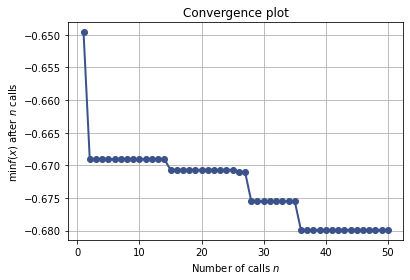

In [139]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

### D.5) Retrain model with the final hyperparameters

In [140]:
get_features_modified

<function __main__.get_features_modified(tokens_POS, idx, suf_length=1, pref_length=3, window_prev=2, window_after=2)>

In [141]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_final.tagger"  # path to the tagger- it will save/access the model from here


feature_minfreq = res_gp.x[0]
c1 = res_gp.x[1]
c2 = res_gp.x[2]

# feature_minfreq = 0
# c1 = 0.4712156694861096
# c2 = 0.4737238668471517

print(f"feature_minfreq = {feature_minfreq}")
print(f"c1 = {c1}")
print(f"c2 = {c2}")

#current best
ct_final = CRFTagger(feature_func=get_features_modified,training_opt={"feature.minfreq":feature_minfreq, "c1": c1, "c2": c2})

print("training tagger...")

#Set train data and tagger path
ct_final.train(training_data_wPOS, TAGGER_PATH)
print("done")

feature_minfreq = 0
c1 = 0.4712156694861096
c2 = 0.4737238668471517
training tagger...
done


In [144]:
# load tagger from saved file

TAGGER_PATH = "crf_final.tagger"  # path to the tagger- it will save/access the model from here


ct_final = CRFTagger(feature_func=get_features_modified)  # initialize tagger
ct_final.set_model_file(TAGGER_PATH)  # load model from file

### D.6) Performance of model with optimal hyperparameters on the validation set

Note that optimizing hyperparameters gave us a 1% boost in f1 score, which is now 68%. We can now retrain the model on the full training set using the final set of features and hyperparameters. 

In [147]:
#Create dataframes of the validation set

#Token Level DF
Validation_DF = Make_Token_Dataframe(model = ct_final, data = validation_data_wPOS)

#Sentence level DF
Validation_Sent_DF = Make_Sentence_Dataframe(data = validation_data_wPOS)

Validation_DF_Full = Make_Full_Dataframe(DF = Validation_DF, Sent_DF = Validation_Sent_DF)

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


In [148]:
# Output the classification report (which you should save each time for comparing your models)

y_val = Validation_DF['y']
preds_val = Validation_DF['pred']

#Save as DF
Class_report_Val_back = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_Val_back_str = classification_report(y_val, preds_val) #


print(f"Classification report of the CRF with modified features\n{'='*100}\n{Class_report_Val_back_str}")
print(precision_recall_fscore_support(y_val, preds_val, average='macro'))  # print out accurate macro score

Classification report of the CRF with modified features
                  precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1231
         B-Award       0.76      0.69      0.73        75
B-Character_Name       0.73      0.41      0.52       212
      B-Director       0.90      0.79      0.84       472
         B-Genre       0.86      0.83      0.84       805
       B-Opinion       0.60      0.34      0.43       160
        B-Origin       0.58      0.49      0.53       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.82      0.38      0.51        24
  B-Relationship       0.76      0.49      0.60       125
    B-Soundtrack       0.86      0.46      0.60        13
          B-Year       0.97      0.98      0.98       703
         I-Actor       0.93      0.93      0.93      1731
         I-Award       0.81      0.82      0.81       202
I-Character_Name       0.74      0.44      0.55       165
      I-Directo

In [8]:
# Classification report of the CRF with modified features
# ====================================================================================================
#                   precision    recall  f1-score   support

#          B-Actor       0.93      0.92      0.93      1231
#          B-Award       0.76      0.69      0.73        75
# B-Character_Name       0.73      0.41      0.52       212
#       B-Director       0.90      0.79      0.84       472
#          B-Genre       0.86      0.83      0.84       805
#        B-Opinion       0.60      0.34      0.43       160
#         B-Origin       0.58      0.49      0.53       159
#           B-Plot       0.49      0.46      0.47      1221
#          B-Quote       0.82      0.38      0.51        24
#   B-Relationship       0.76      0.49      0.60       125
#     B-Soundtrack       0.86      0.46      0.60        13
#           B-Year       0.97      0.98      0.98       703
#          I-Actor       0.93      0.93      0.93      1731
#          I-Award       0.81      0.82      0.81       202
# I-Character_Name       0.74      0.44      0.55       165
#       I-Director       0.90      0.78      0.83       456
#          I-Genre       0.77      0.78      0.78       576
#        I-Opinion       0.28      0.17      0.21        84
#         I-Origin       0.76      0.75      0.76       729
#           I-Plot       0.88      0.93      0.90     11448
#          I-Quote       0.83      0.40      0.54       176
#   I-Relationship       0.75      0.47      0.58       240
#     I-Soundtrack       1.00      0.37      0.54        41
#           I-Year       0.73      0.73      0.73        33
#                O       0.85      0.87      0.86     10223

#         accuracy                           0.85     31304
#        macro avg       0.78      0.63      0.68     31304
#     weighted avg       0.85      0.85      0.85     31304

# (0.7793513103902757, 0.6263670866413039, 0.6798868356290897, None)

## E) Final model results on the test set

### E.1) initialize and pre-process data

In [149]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 

training_data_F = [preProcess_modified(example) for example in raw_training_data]
test_data_F = [preProcess_modified(example) for example in raw_test_data]

In [150]:
print(f'Number of sentences in the full training set: {len(training_data_F)}\n')
print(f'Number of words in the full training set: {sum([len(sent) for sent in training_data_F])}\n')
print(f"quick overview of the full training set \n{training_data_F[0:2]}")

Number of sentences in the full training set: 7816

Number of words in the full training set: 158823

quick overview of the full training set 
[[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')], [('liza@NNP', 'B-Actor'), ('minnelli@NNP', 'I-Actor'), ('and@CC', 'O'), ('joel@NNP', 'B-Actor'), ('gray@NNP', 'I-Actor'), ('won@NNP', 'B-Award'), ('oscars@NNS', 'I-Award'), ('for@IN', 'O'), ('their@PRP$', 'O'), ('roles@NNS', 'O'), ('in@IN', 'O'), ('this@DT', 'O'), ('1972@NN', 'B-Year'), ('movie@NN', 'O'), ('that@WDT', 'B-Plot'), ('follows@VBZ', 'I-Plot'), ('nightclub@NN', 'I-Plot'), ('entertainers@NNS', 'I-Plot'), ('in@IN', 'I-Plo

In [151]:
print(f'Number of sentences in the test set: {len(test_data_F)}\n')
print(f'Number of words in the test set: {sum([len(sent) for sent in test_data_F])}\n')
print(f"quick overview of the full test set \n{test_data_F[0:2]}")

Number of sentences in the test set: 1953

Number of words in the test set: 39035

quick overview of the full test set 
[[('i@PRP', 'O'), ('need@VBP', 'O'), ('that@DT', 'O'), ('movie@NN', 'O'), ('which@WDT', 'O'), ('involves@VBZ', 'O'), ('aliens@NNPPOS', 'B-Plot'), ('invading@NNP', 'I-Plot'), ('earth@NNP', 'I-Plot'), ('in@IN', 'I-Plot'), ('a@DT', 'I-Plot'), ('particular@JJ', 'I-Plot'), ('united@NNP', 'I-Plot'), ('states@NNPS', 'I-Plot'), ('place@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('california@NNP', 'I-Plot')], [('what@WP', 'O'), ('soviet@NNP', 'B-Genre'), ('science@NNP', 'I-Genre'), ('fiction@NN', 'I-Genre'), ('classic@NN', 'B-Opinion'), ('about@IN', 'O'), ('a@DT', 'B-Plot'), ('mysterious@JJ', 'I-Plot'), ('planet@NN', 'I-Plot'), ('was@VBD', 'O'), ('later@RB', 'O'), ('remade@VB', 'B-Relationship'), ('by@IN', 'O'), ('steven@NNP', 'B-Director'), ('soderbergh@NNP', 'I-Director'), ('and@CC', 'O'), ('george@NNP', 'B-Actor'), ('clooney@NNP', 'I-Actor')]]


In [175]:
#Check get feature function before the final training
get_features_modified

<function __main__.get_features_modified(tokens_POS, idx, suf_length=1, pref_length=3, window_prev=2, window_after=2)>

### E.2) Retrain the model on the full training set

In [152]:
# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_full_final.tagger"  # path to the tagger- it will save/access the model from here

#Set hyperparameters
feature_minfreq = res_gp.x[0]
c1 = res_gp.x[1]
c2 = res_gp.x[2]

# feature_minfreq = 0
# c1 = 0.4712156694861096
# c2 = 0.4737238668471517

ct_full_final = CRFTagger(feature_func = get_features_modified,
                          training_opt = {"feature.minfreq":feature_minfreq, 
                                          "c1": c1, 
                                          "c2": c2})  # initialize tagger with get_features function


print("training tagger...")
ct_full_final.train(training_data_F, TAGGER_PATH)
print("done")

training tagger...
done


In [173]:
#Create dataframes of the test set

#Token Level DF
Test_DF = Make_Token_Dataframe(model = ct_full_final, data = test_data_F)

#Sentence level DF
Test_Sent_DF = Make_Sentence_Dataframe(data = test_data_F)

Test_DF_Full = Make_Full_Dataframe(DF = Test_DF,Sent_DF = Test_Sent_DF)

testing tagger...
Done. Token-level DF is generated
Done. Sentence-level DF is generated
Done. Full DF is generated


### E.3) Results on the test set

In [176]:
# Output the classification report (which you should save each time for comparing your models)


y_val = Test_DF['y']
preds_val = Test_DF['pred']


#Save as DF
Class_report_test = pd.DataFrame(classification_report(y_val, preds_val,  output_dict = True)).T 

#Save as string
Class_report_test_str = classification_report(y_val, preds_val) #

Class_report_summaries_test = precision_recall_fscore_support(y_val, preds_val, average='macro')

print(Class_report_test_str)
print(Class_report_summaries_test)  # print out accurate macro score


                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1274
         B-Award       0.74      0.73      0.73        66
B-Character_Name       0.73      0.43      0.54       283
      B-Director       0.86      0.84      0.85       425
         B-Genre       0.83      0.81      0.82       789
       B-Opinion       0.44      0.35      0.39       195
        B-Origin       0.47      0.39      0.43       190
          B-Plot       0.50      0.48      0.49      1577
         B-Quote       0.78      0.45      0.57        47
  B-Relationship       0.76      0.53      0.63       171
    B-Soundtrack       1.00      0.25      0.40         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.90      0.94      0.92      1553
         I-Award       0.81      0.77      0.79       147
I-Character_Name       0.78      0.50      0.61       227
      I-Director       0.91      0.86      0.88       411
         I-Ge

In [9]:
#                   precision    recall  f1-score   support

#          B-Actor       0.92      0.93      0.93      1274
#          B-Award       0.74      0.73      0.73        66
# B-Character_Name       0.73      0.43      0.54       283
#       B-Director       0.86      0.84      0.85       425
#          B-Genre       0.83      0.81      0.82       789
#        B-Opinion       0.44      0.35      0.39       195
#         B-Origin       0.47      0.39      0.43       190
#           B-Plot       0.50      0.48      0.49      1577
#          B-Quote       0.78      0.45      0.57        47
#   B-Relationship       0.76      0.53      0.63       171
#     B-Soundtrack       1.00      0.25      0.40         8
#           B-Year       0.97      0.97      0.97       661
#          I-Actor       0.90      0.94      0.92      1553
#          I-Award       0.81      0.77      0.79       147
# I-Character_Name       0.78      0.50      0.61       227
#       I-Director       0.91      0.86      0.88       411
#          I-Genre       0.80      0.76      0.78       544
#        I-Opinion       0.44      0.19      0.26       143
#         I-Origin       0.67      0.67      0.67       808
#           I-Plot       0.86      0.93      0.90     14661
#          I-Quote       0.76      0.65      0.70       349
#   I-Relationship       0.59      0.50      0.54       289
#     I-Soundtrack       0.80      0.13      0.23        30
#           I-Year       0.68      0.52      0.59        44
#                O       0.87      0.84      0.86     14143

#         accuracy                           0.85     39035
#        macro avg       0.75      0.62      0.66     39035
#     weighted avg       0.84      0.85      0.84     39035

# (0.7542247676847101, 0.6169316613899587, 0.6585038219353798, None)

## F) Final results

### Final model

**Features**:
- Words (window: [-2,2])
- POS tags (window: [-2,2])
- POS tags (window: [-2,2])
- all suffixes up to length 1 (window: [-2,2])
- all prefixes up to length 3 (window: [-2,2]) 
- number indicator (window: [-2,2])

**Hyperparameters**:

- Minimum feature frequency = 0
- c1 = 0.4712156694861096
- c2 = 0.4737238668471517

**Results on the validation set**:

- f1 Macro score = 0.6798868356290897 ~ 68%


**Results on the test set**:

- f1 Macro score = 0.6585038219353798 ~ 66%
